# Load required packages

In [1]:
import ee

import pandas as pd 
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer 
from sklearn.metrics import matthews_corrcoef, roc_auc_score, plot_confusion_matrix

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AY0e-g4kXzKKx7IqscF5uPk840q6nFePDYQ6ixJCYAIygSVBAkKVVqPsxGk

Successfully saved authorization token.


# Load Land Classification Data 

In [3]:
df = pd.read_csv("landclass_locust.csv")
display(df.head(5))


,lat,long,date,lcc
0,-0.559788,37.478215,4/7/2021,Cultivated and managed vegetation/agriculture ...
1,-2.441984,40.161785,7/13/2020,"Open forest, unknown"
2,-0.651670,38.402958,4/4/2021,Urban / built up
3,-0.610328,38.112466,2/5/2021,Cultivated and managed vegetation/agriculture ...
4,0.120728,37.069462,2/11/2021,Cultivated and managed vegetation/agriculture ...


The "date" column needs to be parsed as a date object:

In [4]:
df['date']=pd.DatetimeIndex(df['date'])
display(df.head(5))

,lat,long,date,lcc
0,-0.559788,37.478215,2021-04-07,Cultivated and managed vegetation/agriculture ...
1,-2.441984,40.161785,2020-07-13,"Open forest, unknown"
2,-0.651670,38.402958,2021-04-04,Urban / built up
3,-0.610328,38.112466,2021-02-05,Cultivated and managed vegetation/agriculture ...
4,0.120728,37.069462,2021-02-11,Cultivated and managed vegetation/agriculture ...


Count of Land Cover Classification (LCC) values:

In [5]:
display(df['lcc'].value_counts())

Urban / built up                                            300
Open forest, unknown                                        300
Cultivated and managed vegetation/agriculture (cropland)    300
Name: lcc, dtype: int64

Plot data in Kenya map


/home/plantvillage/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

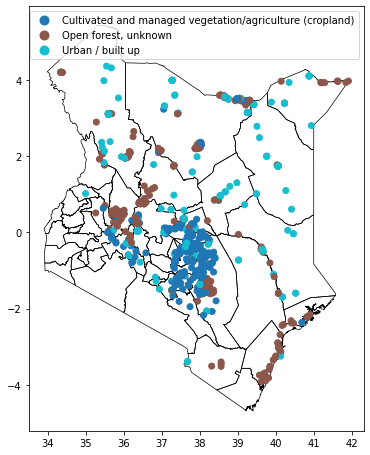

In [6]:
kenya = gpd.read_file(r'kenya_shapefile/County.shp')
gdf = gpd.GeoDataFrame(
    df,
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(df.long, df.lat)])


fig, ax = plt.subplots(1, 1,figsize=(6, 10))

kenya.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)#color = 'yellow')
gdf.plot(column = 'lcc', ax = ax, legend=True)

# Extract Sentinel2 Band Values to Points

Create two date columns to define the date period of the Sentinel2 images

In [7]:
df['date_min']= df['date'] -  pd.to_timedelta(16, unit='d')
df['date_max']= df['date'] +  pd.to_timedelta(16, unit='d')
df.head()

,lat,long,date,lcc,geometry,date_min,date_max
0,-0.559788,37.478215,2021-04-07,Cultivated and managed vegetation/agriculture ...,POINT (37.47821 -0.55979),2021-03-22,2021-04-23
1,-2.441984,40.161785,2020-07-13,"Open forest, unknown",POINT (40.16179 -2.44198),2020-06-27,2020-07-29
2,-0.651670,38.402958,2021-04-04,Urban / built up,POINT (38.40296 -0.65167),2021-03-19,2021-04-20
3,-0.610328,38.112466,2021-02-05,Cultivated and managed vegetation/agriculture ...,POINT (38.11247 -0.61033),2021-01-20,2021-02-21
4,0.120728,37.069462,2021-02-11,Cultivated and managed vegetation/agriculture ...,POINT (37.06946 0.12073),2021-01-26,2021-02-27


In [16]:
def extract_to_point(x):
    bands_s2 = ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']
    lat = x['lat']
    long = x['long']
    p = ee.Geometry.Point([long,lat])
    
    #select image based on following criteria:
    #* within the date range we defined
    #* sort all images by cloud cover 
    #* select images containing our point of image
    #* least cloud-covered images
    
    img = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterDate(x['date_min'].strftime('%Y-%m-%d'), x['date_max'].strftime('%Y-%m-%d')) \
    .sort('CLOUD_COVER') \
    .filterBounds(p) \
    .first()
    try: 
        #extract value from the above image to the point of interest
        temp = img.select(bands_s2).sampleRegions(collection=p, scale=10, geometries=True)
        info = temp.getInfo()
        print("info: ", info)
        print(" ")
        values = info['features'][0]['properties']
        print("values: ", values)
        print(" ")
    except:
        values = {'B11':0, 'B12':0, 'B2':0, 'B3':0, 'B4':0, 'B5':0, 'B6':0, 'B7':0, 'B8':0, 'B8A':0, 'B9':0}
    return values

DO NOT Run this command for the interest of time

In [17]:
### result = df.apply(extract_to_point,axis=1,result_type='reduce')
### s2=pd.DataFrame(result.tolist())
### s2['lat']=df['lat']
### s2['long']=df['long']
### s2['date']=df['date']
### s2['lcc']=df['lcc']

An example showing what extract_to_point function is doing

In [18]:
example = df.iloc[3:5,:].apply(extract_to_point,axis=1,result_type='reduce')
example

info:  {'type': 'FeatureCollection', 'columns': {}, 'properties': {'band_order': ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [38.11249945740845, -0.6103030751136557]}, 'id': '0_0', 'properties': {'B11': 5513, 'B12': 4047, 'B2': 8312, 'B3': 7856, 'B4': 7484, 'B5': 7680, 'B6': 7510, 'B7': 7600, 'B8': 7404, 'B8A': 7480, 'B9': 6623}}]}
 
values:  {'B11': 5513, 'B12': 4047, 'B2': 8312, 'B3': 7856, 'B4': 7484, 'B5': 7680, 'B6': 7510, 'B7': 7600, 'B8': 7404, 'B8A': 7480, 'B9': 6623}
 
info:  {'type': 'FeatureCollection', 'columns': {}, 'properties': {'band_order': ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [37.0694261052473, 0.12075782690290773]}, 'id': '0_0', 'properties': {'B11': 2380, 'B12': 1587, 'B2': 518, 'B3': 739, 'B4': 929, 'B5': 1350, '

3    {'B11': 5513, 'B12': 4047, 'B2': 8312, 'B3': 7...
4    {'B11': 2380, 'B12': 1587, 'B2': 518, 'B3': 73...
dtype: object

Back to mandatory code

For the interest of time, use cached data for the s2 dataset.

In [19]:
s2 = pd.read_csv("s2.csv")
display(s2.head(5))
s2['NDVI'] = (s2['B8'] - s2['B4'])/(s2['B8'] + s2['B4'])
s2.drop(['lat','long','date'],axis = 1, inplace = True)
lcc_code = {'Cultivated and managed vegetation/agriculture (cropland)':0, 
            'Urban / built up':1, 
            'Open forest, unknown':2}
s2['lcc'] = s2['lcc'].map(lcc_code)

display(s2.head(5))

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,lcc,lat,long,date
0,2392,2050,563,781,1204,1488,1995,2187,2195,2346,2440,Cultivated and managed vegetation/agriculture ...,-0.559788,37.478215,2021-04-07
1,2516,1747,306,684,635,1640,3075,3468,3276,3883,3652,"Open forest, unknown",-2.441984,40.161785,2020-07-13
2,5044,4512,3978,4042,4152,4386,4355,4456,4624,4654,6188,Urban / built up,-0.651670,38.402958,2021-04-04
3,5513,4047,8312,7856,7484,7680,7510,7600,7404,7480,6623,Cultivated and managed vegetation/agriculture ...,-0.610328,38.112466,2021-02-05
4,2380,1587,518,739,929,1350,1918,2214,2194,2425,2350,Cultivated and managed vegetation/agriculture ...,0.120728,37.069462,2021-02-11


,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,lcc,NDVI
0,2392,2050,563,781,1204,1488,1995,2187,2195,2346,2440,0,0.291556
1,2516,1747,306,684,635,1640,3075,3468,3276,3883,3652,2,0.675275
2,5044,4512,3978,4042,4152,4386,4355,4456,4624,4654,6188,1,0.053783
3,5513,4047,8312,7856,7484,7680,7510,7600,7404,7480,6623,0,-0.005373
4,2380,1587,518,739,929,1350,1918,2214,2194,2425,2350,0,0.405059


# XGBoost Model 

Split X_train, X_test, y_train, y_test

In [20]:
X = s2.drop(['lcc'],axis = 1)
y = s2['lcc']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=123)

Define searching grids and other parameters in GridSearchCV

In [21]:
estimator = XGBClassifier(
    objective="multi:softprob",
    tree_method="hist",
    seed=42,
    nthread=-1,
)


kfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1234)

parameters = {
    #'eta' : [0.025, 0.5, 0.1],
    'max_depth': [6, 8, 10],
    'n_estimators': range(80, 100, 10),   
    'learning_rate': [0.1, 0.01, 0.05],
    #'min_child_weight': [1, 3, 5],
    #'gamma': [0, 0.5, 1],
    #'subsample': np.arange(0.6 ,0.9, 0.1),
    #'colsample_bytree':[0.5 ,0.75 ,1.0],
    #'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

fit_params = {
    'early_stopping_rounds': 10,
    #'eval_metric': 'mcc',
    'eval_set': [[X_test, y_test]]
}

mcc_scorer = make_scorer(matthews_corrcoef)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring=mcc_scorer,
    cv=kfold,
    verbose=True#,
    #n_jobs=2 #-1
)

Fit the model

In [22]:
grid_search.fit(X_train, y_train, **fit_params)

Fitting 6 folds for each of 18 candidates, totalling 108 fits
[11:40:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08043
[1]	validation_0-mlogloss:1.06847


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-mlogloss:1.05604
[3]	validation_0-mlogloss:1.04696
[4]	validation_0-mlogloss:1.03913
[5]	validation_0-mlogloss:1.03124
[6]	validation_0-mlogloss:1.02939
[7]	validation_0-mlogloss:1.02762
[8]	validation_0-mlogloss:1.02561
[9]	validation_0-mlogloss:1.02204
[10]	validation_0-mlogloss:1.02000
[11]	validation_0-mlogloss:1.01866
[12]	validation_0-mlogloss:1.01913
[13]	validation_0-mlogloss:1.01938
[14]	validation_0-mlogloss:1.01837
[15]	validation_0-mlogloss:1.01988
[16]	validation_0-mlogloss:1.02064
[17]	validation_0-mlogloss:1.02128
[18]	validation_0-mlogloss:1.02358
[19]	validation_0-mlogloss:1.02365
[20]	validation_0-mlogloss:1.02369
[21]	validation_0-mlogloss:1.02461
[22]	validation_0-mlogloss:1.02703
[23]	validation_0-mlogloss:1.02795
[24]	validation_0-mlogloss:1.02774
[11:40:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:40:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08072


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.06587
[2]	validation_0-mlogloss:1.05608
[3]	validation_0-mlogloss:1.04665
[4]	validation_0-mlogloss:1.03932
[5]	validation_0-mlogloss:1.03308
[6]	validation_0-mlogloss:1.03246
[7]	validation_0-mlogloss:1.02830
[8]	validation_0-mlogloss:1.02763
[9]	validation_0-mlogloss:1.02906
[10]	validation_0-mlogloss:1.03322
[11]	validation_0-mlogloss:1.03385
[12]	validation_0-mlogloss:1.03635
[13]	validation_0-mlogloss:1.03730
[14]	validation_0-mlogloss:1.03698
[15]	validation_0-mlogloss:1.03877
[16]	validation_0-mlogloss:1.03932
[17]	validation_0-mlogloss:1.04318
[11:40:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08978
[1]	validation_0-mlogloss:1.08154
[2]	validation_0-mlogloss:1.07734
[3]	validation_0-mlogloss:1.07106
[4]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[4]	validation_0-mlogloss:1.05162
[5]	validation_0-mlogloss:1.05024
[6]	validation_0-mlogloss:1.04565
[7]	validation_0-mlogloss:1.04514
[8]	validation_0-mlogloss:1.04505
[9]	validation_0-mlogloss:1.04677
[10]	validation_0-mlogloss:1.04497
[11]	validation_0-mlogloss:1.04636
[12]	validation_0-mlogloss:1.04967
[13]	validation_0-mlogloss:1.05179
[14]	validation_0-mlogloss:1.05269
[15]	validation_0-mlogloss:1.05345
[16]	validation_0-mlogloss:1.05592
[17]	validation_0-mlogloss:1.05476
[18]	validation_0-mlogloss:1.05594
[19]	validation_0-mlogloss:1.05789
[11:40:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08272
[1]	validation_0-mlogloss:1.06702
[2]	validation_0-mlogloss:1.05880
[3]	validation_0-mlogloss:1.05354
[4]	validation_0-mlogloss:1.05096
[5]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[7]	validation_0-mlogloss:1.02762
[8]	validation_0-mlogloss:1.02561
[9]	validation_0-mlogloss:1.02204
[10]	validation_0-mlogloss:1.02000
[11]	validation_0-mlogloss:1.01866
[12]	validation_0-mlogloss:1.01913
[13]	validation_0-mlogloss:1.01938
[14]	validation_0-mlogloss:1.01837
[15]	validation_0-mlogloss:1.01988
[16]	validation_0-mlogloss:1.02064
[17]	validation_0-mlogloss:1.02128
[18]	validation_0-mlogloss:1.02358
[19]	validation_0-mlogloss:1.02365
[20]	validation_0-mlogloss:1.02369
[21]	validation_0-mlogloss:1.02461
[22]	validation_0-mlogloss:1.02703
[23]	validation_0-mlogloss:1.02795
[11:41:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08125
[1]	validation_0-mlogloss:1.06777
[2]	validation_0-mlogloss:1.05838
[3]	validation_0-mlogloss:1.05147
[4]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[10]	validation_0-mlogloss:1.03322
[11]	validation_0-mlogloss:1.03385
[12]	validation_0-mlogloss:1.03635
[13]	validation_0-mlogloss:1.03730
[14]	validation_0-mlogloss:1.03698
[15]	validation_0-mlogloss:1.03877
[16]	validation_0-mlogloss:1.03932
[17]	validation_0-mlogloss:1.04318
[18]	validation_0-mlogloss:1.04287
[11:41:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08978
[1]	validation_0-mlogloss:1.08154
[2]	validation_0-mlogloss:1.07734
[3]	validation_0-mlogloss:1.07106
[4]	validation_0-mlogloss:1.06768
[5]	validation_0-mlogloss:1.06853
[6]	validation_0-mlogloss:1.06930
[7]	validation_0-mlogloss:1.07096
[8]	validation_0-mlogloss:1.07308
[9]	validation_0-mlogloss:1.07667
[10]	validation_0-mlogloss:1.07891
[11]	validation_0-mlogloss:1.08193
[12]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[13]	validation_0-mlogloss:1.05179
[14]	validation_0-mlogloss:1.05269
[15]	validation_0-mlogloss:1.05345
[16]	validation_0-mlogloss:1.05592
[17]	validation_0-mlogloss:1.05476
[18]	validation_0-mlogloss:1.05594
[19]	validation_0-mlogloss:1.05789
[11:41:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08272
[1]	validation_0-mlogloss:1.06702
[2]	validation_0-mlogloss:1.05880
[3]	validation_0-mlogloss:1.05354
[4]	validation_0-mlogloss:1.05096
[5]	validation_0-mlogloss:1.04842
[6]	validation_0-mlogloss:1.04685
[7]	validation_0-mlogloss:1.04398
[8]	validation_0-mlogloss:1.04371
[9]	validation_0-mlogloss:1.04530
[10]	validation_0-mlogloss:1.04537
[11]	validation_0-mlogloss:1.04873
[12]	validation_0-mlogloss:1.05205
[13]	validation_0-mlogloss:1.05227
[14]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[8]	validation_0-mlogloss:1.03611
[9]	validation_0-mlogloss:1.03826
[10]	validation_0-mlogloss:1.04087
[11]	validation_0-mlogloss:1.04175
[12]	validation_0-mlogloss:1.04333
[13]	validation_0-mlogloss:1.04638
[14]	validation_0-mlogloss:1.04461
[15]	validation_0-mlogloss:1.04814
[16]	validation_0-mlogloss:1.05135
[17]	validation_0-mlogloss:1.05429
[11:41:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08097
[1]	validation_0-mlogloss:1.06449
[2]	validation_0-mlogloss:1.05658
[3]	validation_0-mlogloss:1.05162
[4]	validation_0-mlogloss:1.04830
[5]	validation_0-mlogloss:1.04578
[6]	validation_0-mlogloss:1.04506
[7]	validation_0-mlogloss:1.04352
[8]	validation_0-mlogloss:1.04322
[9]	validation_0-mlogloss:1.04447
[10]	validation_0-mlogloss:1.04728
[11]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[2]	validation_0-mlogloss:1.06748
[3]	validation_0-mlogloss:1.06107
[4]	validation_0-mlogloss:1.05706
[5]	validation_0-mlogloss:1.05148
[6]	validation_0-mlogloss:1.04842
[7]	validation_0-mlogloss:1.04739
[8]	validation_0-mlogloss:1.04590
[9]	validation_0-mlogloss:1.04812
[10]	validation_0-mlogloss:1.04945
[11]	validation_0-mlogloss:1.04996
[12]	validation_0-mlogloss:1.05354
[13]	validation_0-mlogloss:1.05535
[14]	validation_0-mlogloss:1.05950
[15]	validation_0-mlogloss:1.06697
[16]	validation_0-mlogloss:1.07159
[17]	validation_0-mlogloss:1.07736
[18]	validation_0-mlogloss:1.08046
[11:41:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08485
[1]	validation_0-mlogloss:1.07582
[2]	validation_0-mlogloss:1.06787
[3]	validation_0-mlogloss:1.06474
[4]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[7]	validation_0-mlogloss:1.04784
[8]	validation_0-mlogloss:1.04742
[9]	validation_0-mlogloss:1.04609
[10]	validation_0-mlogloss:1.04640
[11]	validation_0-mlogloss:1.04953
[12]	validation_0-mlogloss:1.05225
[13]	validation_0-mlogloss:1.05182
[14]	validation_0-mlogloss:1.05441
[15]	validation_0-mlogloss:1.05764
[16]	validation_0-mlogloss:1.06023
[17]	validation_0-mlogloss:1.06179
[18]	validation_0-mlogloss:1.06331
[11:41:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08064
[1]	validation_0-mlogloss:1.06654
[2]	validation_0-mlogloss:1.05795
[3]	validation_0-mlogloss:1.05228
[4]	validation_0-mlogloss:1.04978
[5]	validation_0-mlogloss:1.04387
[6]	validation_0-mlogloss:1.04467
[7]	validation_0-mlogloss:1.04723
[8]	validation_0-mlogloss:1.04750
[9]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[1]	validation_0-mlogloss:1.06526
[2]	validation_0-mlogloss:1.05677
[3]	validation_0-mlogloss:1.04921
[4]	validation_0-mlogloss:1.04344
[5]	validation_0-mlogloss:1.04072
[6]	validation_0-mlogloss:1.03565
[7]	validation_0-mlogloss:1.03543
[8]	validation_0-mlogloss:1.03611
[9]	validation_0-mlogloss:1.03826
[10]	validation_0-mlogloss:1.04087
[11]	validation_0-mlogloss:1.04175
[12]	validation_0-mlogloss:1.04333
[13]	validation_0-mlogloss:1.04638
[14]	validation_0-mlogloss:1.04461
[15]	validation_0-mlogloss:1.04814
[16]	validation_0-mlogloss:1.05135
[11:41:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08097
[1]	validation_0-mlogloss:1.06449
[2]	validation_0-mlogloss:1.05658
[3]	validation_0-mlogloss:1.05162
[4]	validation_0-mlogloss:1.04830
[5]	validation_0-mlogloss:

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[4]	validation_0-mlogloss:1.05706
[5]	validation_0-mlogloss:1.05148
[6]	validation_0-mlogloss:1.04842
[7]	validation_0-mlogloss:1.04739
[8]	validation_0-mlogloss:1.04590
[9]	validation_0-mlogloss:1.04812
[10]	validation_0-mlogloss:1.04945
[11]	validation_0-mlogloss:1.04996
[12]	validation_0-mlogloss:1.05354
[13]	validation_0-mlogloss:1.05535
[14]	validation_0-mlogloss:1.05950
[15]	validation_0-mlogloss:1.06697
[16]	validation_0-mlogloss:1.07159
[17]	validation_0-mlogloss:1.07736
[11:41:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08485
[1]	validation_0-mlogloss:1.07582
[2]	validation_0-mlogloss:1.06787
[3]	validation_0-mlogloss:1.06474
[4]	validation_0-mlogloss:1.06086
[5]	validation_0-mlogloss:1.05869
[6]	validation_0-mlogloss:1.05684
[7]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[4]	validation_0-mlogloss:1.04763
[5]	validation_0-mlogloss:1.04628
[6]	validation_0-mlogloss:1.04726
[7]	validation_0-mlogloss:1.04784
[8]	validation_0-mlogloss:1.04742
[9]	validation_0-mlogloss:1.04609
[10]	validation_0-mlogloss:1.04640
[11]	validation_0-mlogloss:1.04953
[12]	validation_0-mlogloss:1.05225
[13]	validation_0-mlogloss:1.05182
[14]	validation_0-mlogloss:1.05441
[15]	validation_0-mlogloss:1.05764
[16]	validation_0-mlogloss:1.06023
[17]	validation_0-mlogloss:1.06179
[18]	validation_0-mlogloss:1.06331
[11:41:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08064
[1]	validation_0-mlogloss:1.06654
[2]	validation_0-mlogloss:1.05795
[3]	validation_0-mlogloss:1.05228
[4]	validation_0-mlogloss:1.04978
[5]	validation_0-mlogloss:1.04387
[6]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[2]	validation_0-mlogloss:1.05558
[3]	validation_0-mlogloss:1.04679
[4]	validation_0-mlogloss:1.04132
[5]	validation_0-mlogloss:1.03894
[6]	validation_0-mlogloss:1.03751
[7]	validation_0-mlogloss:1.04023
[8]	validation_0-mlogloss:1.04042
[9]	validation_0-mlogloss:1.04270
[10]	validation_0-mlogloss:1.04394
[11]	validation_0-mlogloss:1.04767
[12]	validation_0-mlogloss:1.04954
[13]	validation_0-mlogloss:1.05412
[14]	validation_0-mlogloss:1.05859
[15]	validation_0-mlogloss:1.06185
[16]	validation_0-mlogloss:1.06539
[11:41:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07994
[1]	validation_0-mlogloss:1.06470
[2]	validation_0-mlogloss:1.05500
[3]	validation_0-mlogloss:1.04894
[4]	validation_0-mlogloss:1.04674
[5]	validation_0-mlogloss:1.04589
[6]	validation_0-mlogloss:

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[4]	validation_0-mlogloss:1.05865
[5]	validation_0-mlogloss:1.05719
[6]	validation_0-mlogloss:1.05188
[7]	validation_0-mlogloss:1.04904
[8]	validation_0-mlogloss:1.04701
[9]	validation_0-mlogloss:1.04591
[10]	validation_0-mlogloss:1.04722
[11]	validation_0-mlogloss:1.05072
[12]	validation_0-mlogloss:1.05495
[13]	validation_0-mlogloss:1.05933
[14]	validation_0-mlogloss:1.06408
[15]	validation_0-mlogloss:1.07122
[16]	validation_0-mlogloss:1.07670
[17]	validation_0-mlogloss:1.08414
[18]	validation_0-mlogloss:1.08757
[11:41:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08570
[1]	validation_0-mlogloss:1.07997
[2]	validation_0-mlogloss:1.07431
[3]	validation_0-mlogloss:1.07171
[4]	validation_0-mlogloss:1.06499
[5]	validation_0-mlogloss:1.06499
[6]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[11:41:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08002
[1]	validation_0-mlogloss:1.06569
[2]	validation_0-mlogloss:1.05834
[3]	validation_0-mlogloss:1.04964
[4]	validation_0-mlogloss:1.04594
[5]	validation_0-mlogloss:1.04424
[6]	validation_0-mlogloss:1.04295
[7]	validation_0-mlogloss:1.04299
[8]	validation_0-mlogloss:1.04482
[9]	validation_0-mlogloss:1.04836
[10]	validation_0-mlogloss:1.05574
[11]	validation_0-mlogloss:1.06275
[12]	validation_0-mlogloss:1.06746
[13]	validation_0-mlogloss:1.07224
[14]	validation_0-mlogloss:1.08209
[15]	validation_0-mlogloss:1.08818
[16]	validation_0-mlogloss:1.09247
[11:41:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'me

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

[5]	validation_0-mlogloss:1.04773
[6]	validation_0-mlogloss:1.04918
[7]	validation_0-mlogloss:1.05253
[8]	validation_0-mlogloss:1.05065
[9]	validation_0-mlogloss:1.05507
[10]	validation_0-mlogloss:1.05865
[11]	validation_0-mlogloss:1.06081
[12]	validation_0-mlogloss:1.06864
[13]	validation_0-mlogloss:1.07150
[11:41:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07869
[1]	validation_0-mlogloss:1.06503
[2]	validation_0-mlogloss:1.05558
[3]	validation_0-mlogloss:1.04679
[4]	validation_0-mlogloss:1.04132
[5]	validation_0-mlogloss:1.03894
[6]	validation_0-mlogloss:1.03751
[7]	validation_0-mlogloss:1.04023
[8]	validation_0-mlogloss:1.04042
[9]	validation_0-mlogloss:1.04270
[10]	validation_0-mlogloss:1.04394
[11]	validation_0-mlogloss:1.04767
[12]	validation_0-mlogloss:

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[6]	validation_0-mlogloss:1.04537
[7]	validation_0-mlogloss:1.04655
[8]	validation_0-mlogloss:1.04712
[9]	validation_0-mlogloss:1.04570
[10]	validation_0-mlogloss:1.04696
[11]	validation_0-mlogloss:1.05066
[12]	validation_0-mlogloss:1.05170
[13]	validation_0-mlogloss:1.05755
[14]	validation_0-mlogloss:1.06368
[15]	validation_0-mlogloss:1.07045
[11:41:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08170
[1]	validation_0-mlogloss:1.07384
[2]	validation_0-mlogloss:1.06559
[3]	validation_0-mlogloss:1.06208
[4]	validation_0-mlogloss:1.05865
[5]	validation_0-mlogloss:1.05719
[6]	validation_0-mlogloss:1.05188
[7]	validation_0-mlogloss:1.04904
[8]	validation_0-mlogloss:1.04701
[9]	validation_0-mlogloss:1.04591
[10]	validation_0-mlogloss:1.04722
[11]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[2]	validation_0-mlogloss:1.07431
[3]	validation_0-mlogloss:1.07171
[4]	validation_0-mlogloss:1.06499
[5]	validation_0-mlogloss:1.06499
[6]	validation_0-mlogloss:1.06295
[7]	validation_0-mlogloss:1.06329
[8]	validation_0-mlogloss:1.06039
[9]	validation_0-mlogloss:1.06018
[10]	validation_0-mlogloss:1.06205
[11]	validation_0-mlogloss:1.06418
[12]	validation_0-mlogloss:1.06630
[13]	validation_0-mlogloss:1.06997
[14]	validation_0-mlogloss:1.07426
[15]	validation_0-mlogloss:1.07974
[16]	validation_0-mlogloss:1.08246
[17]	validation_0-mlogloss:1.08809
[18]	validation_0-mlogloss:1.09595
[11:41:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08002
[1]	validation_0-mlogloss:1.06569
[2]	validation_0-mlogloss:1.05834
[3]	validation_0-mlogloss:1.04964
[4]	validation_0-mloglos

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[6]	validation_0-mlogloss:1.04918
[7]	validation_0-mlogloss:1.05253
[8]	validation_0-mlogloss:1.05065
[9]	validation_0-mlogloss:1.05507
[10]	validation_0-mlogloss:1.05865
[11]	validation_0-mlogloss:1.06081
[12]	validation_0-mlogloss:1.06864
[13]	validation_0-mlogloss:1.07150
[14]	validation_0-mlogloss:1.08130
[11:41:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09665
[1]	validation_0-mlogloss:1.09478
[2]	validation_0-mlogloss:1.09286
[3]	validation_0-mlogloss:1.09097
[4]	validation_0-mlogloss:1.08918
[5]	validation_0-mlogloss:1.08735
[6]	validation_0-mlogloss:1.08551
[7]	validation_0-mlogloss:1.08384
[8]	validation_0-mlogloss:1.08252
[9]	validation_0-mlogloss:1.08082
[10]	validation_0-mlogloss:1.07959
[11]	validation_0-mlogloss:1.07804
[12]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[39]	validation_0-mlogloss:1.04876
[40]	validation_0-mlogloss:1.04810
[41]	validation_0-mlogloss:1.04736
[42]	validation_0-mlogloss:1.04667
[43]	validation_0-mlogloss:1.04592
[44]	validation_0-mlogloss:1.04537
[45]	validation_0-mlogloss:1.04477
[46]	validation_0-mlogloss:1.04409
[47]	validation_0-mlogloss:1.04344
[48]	validation_0-mlogloss:1.04269
[49]	validation_0-mlogloss:1.04213
[50]	validation_0-mlogloss:1.04156
[51]	validation_0-mlogloss:1.04123
[52]	validation_0-mlogloss:1.04075
[53]	validation_0-mlogloss:1.04023
[54]	validation_0-mlogloss:1.03991
[55]	validation_0-mlogloss:1.03940
[56]	validation_0-mlogloss:1.03880
[57]	validation_0-mlogloss:1.03857
[58]	validation_0-mlogloss:1.03828
[59]	validation_0-mlogloss:1.03783
[60]	validation_0-mlogloss:1.03747
[61]	validation_0-mlogloss:1.03682
[62]	validation_0-mlogloss:1.03662
[63]	validation_0-mlogloss:1.03623
[64]	validation_0-mlogloss:1.03569
[65]	validation_0-mlogloss:1.03542
[66]	validation_0-mlogloss:1.03498
[67]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[31]	validation_0-mlogloss:1.05639
[32]	validation_0-mlogloss:1.05575
[33]	validation_0-mlogloss:1.05515
[34]	validation_0-mlogloss:1.05448
[35]	validation_0-mlogloss:1.05371
[36]	validation_0-mlogloss:1.05327
[37]	validation_0-mlogloss:1.05267
[38]	validation_0-mlogloss:1.05223
[39]	validation_0-mlogloss:1.05172
[40]	validation_0-mlogloss:1.05136
[41]	validation_0-mlogloss:1.05086
[42]	validation_0-mlogloss:1.05038
[43]	validation_0-mlogloss:1.04999
[44]	validation_0-mlogloss:1.04974
[45]	validation_0-mlogloss:1.04915
[46]	validation_0-mlogloss:1.04878
[47]	validation_0-mlogloss:1.04834
[48]	validation_0-mlogloss:1.04808
[49]	validation_0-mlogloss:1.04767
[50]	validation_0-mlogloss:1.04728
[51]	validation_0-mlogloss:1.04703
[52]	validation_0-mlogloss:1.04658
[53]	validation_0-mlogloss:1.04616
[54]	validation_0-mlogloss:1.04588
[55]	validation_0-mlogloss:1.04550
[56]	validation_0-mlogloss:1.04528
[57]	validation_0-mlogloss:1.04490
[58]	validation_0-mlogloss:1.04475
[59]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[36]	validation_0-mlogloss:1.05045
[37]	validation_0-mlogloss:1.04954
[38]	validation_0-mlogloss:1.04881
[39]	validation_0-mlogloss:1.04790
[40]	validation_0-mlogloss:1.04721
[41]	validation_0-mlogloss:1.04636
[42]	validation_0-mlogloss:1.04584
[43]	validation_0-mlogloss:1.04522
[44]	validation_0-mlogloss:1.04446
[45]	validation_0-mlogloss:1.04381
[46]	validation_0-mlogloss:1.04310
[47]	validation_0-mlogloss:1.04234
[48]	validation_0-mlogloss:1.04171
[49]	validation_0-mlogloss:1.04093
[50]	validation_0-mlogloss:1.04025
[51]	validation_0-mlogloss:1.03962
[52]	validation_0-mlogloss:1.03907
[53]	validation_0-mlogloss:1.03842
[54]	validation_0-mlogloss:1.03801
[55]	validation_0-mlogloss:1.03771
[56]	validation_0-mlogloss:1.03729
[57]	validation_0-mlogloss:1.03701
[58]	validation_0-mlogloss:1.03673
[59]	validation_0-mlogloss:1.03627
[60]	validation_0-mlogloss:1.03567
[61]	validation_0-mlogloss:1.03531
[62]	validation_0-mlogloss:1.03456
[63]	validation_0-mlogloss:1.03421
[64]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[33]	validation_0-mlogloss:1.07429
[34]	validation_0-mlogloss:1.07351
[35]	validation_0-mlogloss:1.07283
[36]	validation_0-mlogloss:1.07222
[37]	validation_0-mlogloss:1.07157
[38]	validation_0-mlogloss:1.07091
[39]	validation_0-mlogloss:1.07045
[40]	validation_0-mlogloss:1.06983
[41]	validation_0-mlogloss:1.06933
[42]	validation_0-mlogloss:1.06889
[43]	validation_0-mlogloss:1.06839
[44]	validation_0-mlogloss:1.06781
[45]	validation_0-mlogloss:1.06741
[46]	validation_0-mlogloss:1.06696
[47]	validation_0-mlogloss:1.06639
[48]	validation_0-mlogloss:1.06592
[49]	validation_0-mlogloss:1.06570
[50]	validation_0-mlogloss:1.06571
[51]	validation_0-mlogloss:1.06584
[52]	validation_0-mlogloss:1.06585
[53]	validation_0-mlogloss:1.06588
[54]	validation_0-mlogloss:1.06584
[55]	validation_0-mlogloss:1.06592
[56]	validation_0-mlogloss:1.06593
[57]	validation_0-mlogloss:1.06595
[58]	validation_0-mlogloss:1.06594
[11:41:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluat

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[40]	validation_0-mlogloss:1.05849
[41]	validation_0-mlogloss:1.05807
[42]	validation_0-mlogloss:1.05769
[43]	validation_0-mlogloss:1.05706
[44]	validation_0-mlogloss:1.05693
[45]	validation_0-mlogloss:1.05644
[46]	validation_0-mlogloss:1.05606
[47]	validation_0-mlogloss:1.05566
[48]	validation_0-mlogloss:1.05515
[49]	validation_0-mlogloss:1.05494
[50]	validation_0-mlogloss:1.05467
[51]	validation_0-mlogloss:1.05422
[52]	validation_0-mlogloss:1.05394
[53]	validation_0-mlogloss:1.05364
[54]	validation_0-mlogloss:1.05342
[55]	validation_0-mlogloss:1.05297
[56]	validation_0-mlogloss:1.05265
[57]	validation_0-mlogloss:1.05273
[58]	validation_0-mlogloss:1.05254
[59]	validation_0-mlogloss:1.05216
[60]	validation_0-mlogloss:1.05186
[61]	validation_0-mlogloss:1.05161
[62]	validation_0-mlogloss:1.05143
[63]	validation_0-mlogloss:1.05100
[64]	validation_0-mlogloss:1.05075
[65]	validation_0-mlogloss:1.05043
[66]	validation_0-mlogloss:1.05003
[67]	validation_0-mlogloss:1.04963
[68]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[34]	validation_0-mlogloss:1.05614
[35]	validation_0-mlogloss:1.05569
[36]	validation_0-mlogloss:1.05504
[37]	validation_0-mlogloss:1.05434
[38]	validation_0-mlogloss:1.05373
[39]	validation_0-mlogloss:1.05304
[40]	validation_0-mlogloss:1.05244
[41]	validation_0-mlogloss:1.05183
[42]	validation_0-mlogloss:1.05133
[43]	validation_0-mlogloss:1.05067
[44]	validation_0-mlogloss:1.05009
[45]	validation_0-mlogloss:1.04947
[46]	validation_0-mlogloss:1.04912
[47]	validation_0-mlogloss:1.04855
[48]	validation_0-mlogloss:1.04800
[49]	validation_0-mlogloss:1.04754
[50]	validation_0-mlogloss:1.04700
[51]	validation_0-mlogloss:1.04656
[52]	validation_0-mlogloss:1.04613
[53]	validation_0-mlogloss:1.04557
[54]	validation_0-mlogloss:1.04513
[55]	validation_0-mlogloss:1.04479
[56]	validation_0-mlogloss:1.04439
[57]	validation_0-mlogloss:1.04411
[58]	validation_0-mlogloss:1.04391
[59]	validation_0-mlogloss:1.04346
[60]	validation_0-mlogloss:1.04344
[61]	validation_0-mlogloss:1.04322
[62]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[37]	validation_0-mlogloss:1.05046
[38]	validation_0-mlogloss:1.04977
[39]	validation_0-mlogloss:1.04876
[40]	validation_0-mlogloss:1.04810
[41]	validation_0-mlogloss:1.04736
[42]	validation_0-mlogloss:1.04667
[43]	validation_0-mlogloss:1.04592
[44]	validation_0-mlogloss:1.04537
[45]	validation_0-mlogloss:1.04477
[46]	validation_0-mlogloss:1.04409
[47]	validation_0-mlogloss:1.04344
[48]	validation_0-mlogloss:1.04269
[49]	validation_0-mlogloss:1.04213
[50]	validation_0-mlogloss:1.04156
[51]	validation_0-mlogloss:1.04123
[52]	validation_0-mlogloss:1.04075
[53]	validation_0-mlogloss:1.04023
[54]	validation_0-mlogloss:1.03991
[55]	validation_0-mlogloss:1.03940
[56]	validation_0-mlogloss:1.03880
[57]	validation_0-mlogloss:1.03857
[58]	validation_0-mlogloss:1.03828
[59]	validation_0-mlogloss:1.03783
[60]	validation_0-mlogloss:1.03747
[61]	validation_0-mlogloss:1.03682
[62]	validation_0-mlogloss:1.03662
[63]	validation_0-mlogloss:1.03623
[64]	validation_0-mlogloss:1.03569
[65]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[42]	validation_0-mlogloss:1.05038
[43]	validation_0-mlogloss:1.04999
[44]	validation_0-mlogloss:1.04974
[45]	validation_0-mlogloss:1.04915
[46]	validation_0-mlogloss:1.04878
[47]	validation_0-mlogloss:1.04834
[48]	validation_0-mlogloss:1.04808
[49]	validation_0-mlogloss:1.04767
[50]	validation_0-mlogloss:1.04728
[51]	validation_0-mlogloss:1.04703
[52]	validation_0-mlogloss:1.04658
[53]	validation_0-mlogloss:1.04616
[54]	validation_0-mlogloss:1.04588
[55]	validation_0-mlogloss:1.04550
[56]	validation_0-mlogloss:1.04528
[57]	validation_0-mlogloss:1.04490
[58]	validation_0-mlogloss:1.04475
[59]	validation_0-mlogloss:1.04468
[60]	validation_0-mlogloss:1.04444
[61]	validation_0-mlogloss:1.04414
[62]	validation_0-mlogloss:1.04389
[63]	validation_0-mlogloss:1.04364
[64]	validation_0-mlogloss:1.04327
[65]	validation_0-mlogloss:1.04303
[66]	validation_0-mlogloss:1.04277
[67]	validation_0-mlogloss:1.04252
[68]	validation_0-mlogloss:1.04223
[69]	validation_0-mlogloss:1.04194
[70]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[39]	validation_0-mlogloss:1.04790
[40]	validation_0-mlogloss:1.04721
[41]	validation_0-mlogloss:1.04636
[42]	validation_0-mlogloss:1.04584
[43]	validation_0-mlogloss:1.04522
[44]	validation_0-mlogloss:1.04446
[45]	validation_0-mlogloss:1.04381
[46]	validation_0-mlogloss:1.04310
[47]	validation_0-mlogloss:1.04234
[48]	validation_0-mlogloss:1.04171
[49]	validation_0-mlogloss:1.04093
[50]	validation_0-mlogloss:1.04025
[51]	validation_0-mlogloss:1.03962
[52]	validation_0-mlogloss:1.03907
[53]	validation_0-mlogloss:1.03842
[54]	validation_0-mlogloss:1.03801
[55]	validation_0-mlogloss:1.03771
[56]	validation_0-mlogloss:1.03729
[57]	validation_0-mlogloss:1.03701
[58]	validation_0-mlogloss:1.03673
[59]	validation_0-mlogloss:1.03627
[60]	validation_0-mlogloss:1.03567
[61]	validation_0-mlogloss:1.03531
[62]	validation_0-mlogloss:1.03456
[63]	validation_0-mlogloss:1.03421
[64]	validation_0-mlogloss:1.03375
[65]	validation_0-mlogloss:1.03357
[66]	validation_0-mlogloss:1.03310
[67]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[37]	validation_0-mlogloss:1.07157
[38]	validation_0-mlogloss:1.07091
[39]	validation_0-mlogloss:1.07045
[40]	validation_0-mlogloss:1.06983
[41]	validation_0-mlogloss:1.06933
[42]	validation_0-mlogloss:1.06889
[43]	validation_0-mlogloss:1.06839
[44]	validation_0-mlogloss:1.06781
[45]	validation_0-mlogloss:1.06741
[46]	validation_0-mlogloss:1.06696
[47]	validation_0-mlogloss:1.06639
[48]	validation_0-mlogloss:1.06592
[49]	validation_0-mlogloss:1.06570
[50]	validation_0-mlogloss:1.06571
[51]	validation_0-mlogloss:1.06584
[52]	validation_0-mlogloss:1.06585
[53]	validation_0-mlogloss:1.06588
[54]	validation_0-mlogloss:1.06584
[55]	validation_0-mlogloss:1.06592
[56]	validation_0-mlogloss:1.06593
[57]	validation_0-mlogloss:1.06595
[58]	validation_0-mlogloss:1.06594
[59]	validation_0-mlogloss:1.06596
[11:41:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly s

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[40]	validation_0-mlogloss:1.05849
[41]	validation_0-mlogloss:1.05807
[42]	validation_0-mlogloss:1.05769
[43]	validation_0-mlogloss:1.05706
[44]	validation_0-mlogloss:1.05693
[45]	validation_0-mlogloss:1.05644
[46]	validation_0-mlogloss:1.05606
[47]	validation_0-mlogloss:1.05566
[48]	validation_0-mlogloss:1.05515
[49]	validation_0-mlogloss:1.05494
[50]	validation_0-mlogloss:1.05467
[51]	validation_0-mlogloss:1.05422
[52]	validation_0-mlogloss:1.05394
[53]	validation_0-mlogloss:1.05364
[54]	validation_0-mlogloss:1.05342
[55]	validation_0-mlogloss:1.05297
[56]	validation_0-mlogloss:1.05265
[57]	validation_0-mlogloss:1.05273
[58]	validation_0-mlogloss:1.05254
[59]	validation_0-mlogloss:1.05216
[60]	validation_0-mlogloss:1.05186
[61]	validation_0-mlogloss:1.05161
[62]	validation_0-mlogloss:1.05143
[63]	validation_0-mlogloss:1.05100
[64]	validation_0-mlogloss:1.05075
[65]	validation_0-mlogloss:1.05043
[66]	validation_0-mlogloss:1.05003
[67]	validation_0-mlogloss:1.04963
[68]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[37]	validation_0-mlogloss:1.05434
[38]	validation_0-mlogloss:1.05373
[39]	validation_0-mlogloss:1.05304
[40]	validation_0-mlogloss:1.05244
[41]	validation_0-mlogloss:1.05183
[42]	validation_0-mlogloss:1.05133
[43]	validation_0-mlogloss:1.05067
[44]	validation_0-mlogloss:1.05009
[45]	validation_0-mlogloss:1.04947
[46]	validation_0-mlogloss:1.04912
[47]	validation_0-mlogloss:1.04855
[48]	validation_0-mlogloss:1.04800
[49]	validation_0-mlogloss:1.04754
[50]	validation_0-mlogloss:1.04700
[51]	validation_0-mlogloss:1.04656
[52]	validation_0-mlogloss:1.04613
[53]	validation_0-mlogloss:1.04557
[54]	validation_0-mlogloss:1.04513
[55]	validation_0-mlogloss:1.04479
[56]	validation_0-mlogloss:1.04439
[57]	validation_0-mlogloss:1.04411
[58]	validation_0-mlogloss:1.04391
[59]	validation_0-mlogloss:1.04346
[60]	validation_0-mlogloss:1.04344
[61]	validation_0-mlogloss:1.04322
[62]	validation_0-mlogloss:1.04285
[63]	validation_0-mlogloss:1.04269
[64]	validation_0-mlogloss:1.04241
[65]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[32]	validation_0-mlogloss:1.05558
[33]	validation_0-mlogloss:1.05499
[34]	validation_0-mlogloss:1.05438
[35]	validation_0-mlogloss:1.05384
[36]	validation_0-mlogloss:1.05299
[37]	validation_0-mlogloss:1.05234
[38]	validation_0-mlogloss:1.05197
[39]	validation_0-mlogloss:1.05126
[40]	validation_0-mlogloss:1.05059
[41]	validation_0-mlogloss:1.05001
[42]	validation_0-mlogloss:1.04950
[43]	validation_0-mlogloss:1.04908
[44]	validation_0-mlogloss:1.04868
[45]	validation_0-mlogloss:1.04817
[46]	validation_0-mlogloss:1.04768
[47]	validation_0-mlogloss:1.04729
[48]	validation_0-mlogloss:1.04671
[49]	validation_0-mlogloss:1.04606
[50]	validation_0-mlogloss:1.04521
[51]	validation_0-mlogloss:1.04480
[52]	validation_0-mlogloss:1.04412
[53]	validation_0-mlogloss:1.04373
[54]	validation_0-mlogloss:1.04346
[55]	validation_0-mlogloss:1.04325
[56]	validation_0-mlogloss:1.04310
[57]	validation_0-mlogloss:1.04304
[58]	validation_0-mlogloss:1.04300
[59]	validation_0-mlogloss:1.04283
[60]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[34]	validation_0-mlogloss:1.05493
[35]	validation_0-mlogloss:1.05432
[36]	validation_0-mlogloss:1.05387
[37]	validation_0-mlogloss:1.05335
[38]	validation_0-mlogloss:1.05297
[39]	validation_0-mlogloss:1.05259
[40]	validation_0-mlogloss:1.05225
[41]	validation_0-mlogloss:1.05184
[42]	validation_0-mlogloss:1.05154
[43]	validation_0-mlogloss:1.05129
[44]	validation_0-mlogloss:1.05066
[45]	validation_0-mlogloss:1.05044
[46]	validation_0-mlogloss:1.05019
[47]	validation_0-mlogloss:1.04985
[48]	validation_0-mlogloss:1.04973
[49]	validation_0-mlogloss:1.04939
[50]	validation_0-mlogloss:1.04866
[51]	validation_0-mlogloss:1.04809
[52]	validation_0-mlogloss:1.04742
[53]	validation_0-mlogloss:1.04717
[54]	validation_0-mlogloss:1.04696
[55]	validation_0-mlogloss:1.04631
[56]	validation_0-mlogloss:1.04623
[57]	validation_0-mlogloss:1.04601
[58]	validation_0-mlogloss:1.04589
[59]	validation_0-mlogloss:1.04570
[60]	validation_0-mlogloss:1.04576
[61]	validation_0-mlogloss:1.04560
[62]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[32]	validation_0-mlogloss:1.06432
[33]	validation_0-mlogloss:1.06354
[34]	validation_0-mlogloss:1.06291
[35]	validation_0-mlogloss:1.06254
[36]	validation_0-mlogloss:1.06184
[37]	validation_0-mlogloss:1.06101
[38]	validation_0-mlogloss:1.06037
[39]	validation_0-mlogloss:1.05964
[40]	validation_0-mlogloss:1.05885
[41]	validation_0-mlogloss:1.05830
[42]	validation_0-mlogloss:1.05775
[43]	validation_0-mlogloss:1.05718
[44]	validation_0-mlogloss:1.05666
[45]	validation_0-mlogloss:1.05624
[46]	validation_0-mlogloss:1.05584
[47]	validation_0-mlogloss:1.05537
[48]	validation_0-mlogloss:1.05498
[49]	validation_0-mlogloss:1.05473
[50]	validation_0-mlogloss:1.05417
[51]	validation_0-mlogloss:1.05394
[52]	validation_0-mlogloss:1.05361
[53]	validation_0-mlogloss:1.05329
[54]	validation_0-mlogloss:1.05289
[55]	validation_0-mlogloss:1.05246
[56]	validation_0-mlogloss:1.05220
[57]	validation_0-mlogloss:1.05186
[58]	validation_0-mlogloss:1.05137
[59]	validation_0-mlogloss:1.05097
[60]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[30]	validation_0-mlogloss:1.07026
[31]	validation_0-mlogloss:1.06954
[32]	validation_0-mlogloss:1.06936
[33]	validation_0-mlogloss:1.06875
[34]	validation_0-mlogloss:1.06830
[35]	validation_0-mlogloss:1.06820
[36]	validation_0-mlogloss:1.06790
[37]	validation_0-mlogloss:1.06769
[38]	validation_0-mlogloss:1.06739
[39]	validation_0-mlogloss:1.06687
[40]	validation_0-mlogloss:1.06674
[41]	validation_0-mlogloss:1.06640
[42]	validation_0-mlogloss:1.06614
[43]	validation_0-mlogloss:1.06565
[44]	validation_0-mlogloss:1.06497
[45]	validation_0-mlogloss:1.06448
[46]	validation_0-mlogloss:1.06374
[47]	validation_0-mlogloss:1.06335
[48]	validation_0-mlogloss:1.06250
[49]	validation_0-mlogloss:1.06192
[50]	validation_0-mlogloss:1.06114
[51]	validation_0-mlogloss:1.06068
[52]	validation_0-mlogloss:1.06043
[53]	validation_0-mlogloss:1.05977
[54]	validation_0-mlogloss:1.05907
[55]	validation_0-mlogloss:1.05849
[56]	validation_0-mlogloss:1.05803
[57]	validation_0-mlogloss:1.05764
[58]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[34]	validation_0-mlogloss:1.05594
[35]	validation_0-mlogloss:1.05515
[36]	validation_0-mlogloss:1.05464
[37]	validation_0-mlogloss:1.05393
[38]	validation_0-mlogloss:1.05334
[39]	validation_0-mlogloss:1.05266
[40]	validation_0-mlogloss:1.05206
[41]	validation_0-mlogloss:1.05160
[42]	validation_0-mlogloss:1.05123
[43]	validation_0-mlogloss:1.05099
[44]	validation_0-mlogloss:1.05056
[45]	validation_0-mlogloss:1.05011
[46]	validation_0-mlogloss:1.04951
[47]	validation_0-mlogloss:1.04904
[48]	validation_0-mlogloss:1.04875
[49]	validation_0-mlogloss:1.04855
[50]	validation_0-mlogloss:1.04822
[51]	validation_0-mlogloss:1.04791
[52]	validation_0-mlogloss:1.04754
[53]	validation_0-mlogloss:1.04727
[54]	validation_0-mlogloss:1.04713
[55]	validation_0-mlogloss:1.04687
[56]	validation_0-mlogloss:1.04666
[57]	validation_0-mlogloss:1.04646
[58]	validation_0-mlogloss:1.04658
[59]	validation_0-mlogloss:1.04658
[60]	validation_0-mlogloss:1.04645
[61]	validation_0-mlogloss:1.04628
[62]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-mlogloss:1.07793
[12]	validation_0-mlogloss:1.07654
[13]	validation_0-mlogloss:1.07506
[14]	validation_0-mlogloss:1.07377
[15]	validation_0-mlogloss:1.07261
[16]	validation_0-mlogloss:1.07122
[17]	validation_0-mlogloss:1.07008
[18]	validation_0-mlogloss:1.06909
[19]	validation_0-mlogloss:1.06790
[20]	validation_0-mlogloss:1.06701
[21]	validation_0-mlogloss:1.06589
[22]	validation_0-mlogloss:1.06497
[23]	validation_0-mlogloss:1.06391
[24]	validation_0-mlogloss:1.06338
[25]	validation_0-mlogloss:1.06268
[26]	validation_0-mlogloss:1.06222
[27]	validation_0-mlogloss:1.06162
[28]	validation_0-mlogloss:1.06103
[29]	validation_0-mlogloss:1.06062
[30]	validation_0-mlogloss:1.06026
[31]	validation_0-mlogloss:1.06000
[32]	validation_0-mlogloss:1.05957
[33]	validation_0-mlogloss:1.05902
[34]	validation_0-mlogloss:1.05862
[35]	validation_0-mlogloss:1.05808
[36]	validation_0-mlogloss:1.05758
[37]	validation_0-mlogloss:1.05713
[38]	validation_0-mlogloss:1.05669
[39]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[30]	validation_0-mlogloss:1.05730
[31]	validation_0-mlogloss:1.05660
[32]	validation_0-mlogloss:1.05558
[33]	validation_0-mlogloss:1.05499
[34]	validation_0-mlogloss:1.05438
[35]	validation_0-mlogloss:1.05384
[36]	validation_0-mlogloss:1.05299
[37]	validation_0-mlogloss:1.05234
[38]	validation_0-mlogloss:1.05197
[39]	validation_0-mlogloss:1.05126
[40]	validation_0-mlogloss:1.05059
[41]	validation_0-mlogloss:1.05001
[42]	validation_0-mlogloss:1.04950
[43]	validation_0-mlogloss:1.04908
[44]	validation_0-mlogloss:1.04868
[45]	validation_0-mlogloss:1.04817
[46]	validation_0-mlogloss:1.04768
[47]	validation_0-mlogloss:1.04729
[48]	validation_0-mlogloss:1.04671
[49]	validation_0-mlogloss:1.04606
[50]	validation_0-mlogloss:1.04521
[51]	validation_0-mlogloss:1.04480
[52]	validation_0-mlogloss:1.04412
[53]	validation_0-mlogloss:1.04373
[54]	validation_0-mlogloss:1.04346
[55]	validation_0-mlogloss:1.04325
[56]	validation_0-mlogloss:1.04310
[57]	validation_0-mlogloss:1.04304
[58]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[30]	validation_0-mlogloss:1.05720
[31]	validation_0-mlogloss:1.05668
[32]	validation_0-mlogloss:1.05613
[33]	validation_0-mlogloss:1.05541
[34]	validation_0-mlogloss:1.05493
[35]	validation_0-mlogloss:1.05432
[36]	validation_0-mlogloss:1.05387
[37]	validation_0-mlogloss:1.05335
[38]	validation_0-mlogloss:1.05297
[39]	validation_0-mlogloss:1.05259
[40]	validation_0-mlogloss:1.05225
[41]	validation_0-mlogloss:1.05184
[42]	validation_0-mlogloss:1.05154
[43]	validation_0-mlogloss:1.05129
[44]	validation_0-mlogloss:1.05066
[45]	validation_0-mlogloss:1.05044
[46]	validation_0-mlogloss:1.05019
[47]	validation_0-mlogloss:1.04985
[48]	validation_0-mlogloss:1.04973
[49]	validation_0-mlogloss:1.04939
[50]	validation_0-mlogloss:1.04866
[51]	validation_0-mlogloss:1.04809
[52]	validation_0-mlogloss:1.04742
[53]	validation_0-mlogloss:1.04717
[54]	validation_0-mlogloss:1.04696
[55]	validation_0-mlogloss:1.04631
[56]	validation_0-mlogloss:1.04623
[57]	validation_0-mlogloss:1.04601
[58]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[32]	validation_0-mlogloss:1.06432
[33]	validation_0-mlogloss:1.06354
[34]	validation_0-mlogloss:1.06291
[35]	validation_0-mlogloss:1.06254
[36]	validation_0-mlogloss:1.06184
[37]	validation_0-mlogloss:1.06101
[38]	validation_0-mlogloss:1.06037
[39]	validation_0-mlogloss:1.05964
[40]	validation_0-mlogloss:1.05885
[41]	validation_0-mlogloss:1.05830
[42]	validation_0-mlogloss:1.05775
[43]	validation_0-mlogloss:1.05718
[44]	validation_0-mlogloss:1.05666
[45]	validation_0-mlogloss:1.05624
[46]	validation_0-mlogloss:1.05584
[47]	validation_0-mlogloss:1.05537
[48]	validation_0-mlogloss:1.05498
[49]	validation_0-mlogloss:1.05473
[50]	validation_0-mlogloss:1.05417
[51]	validation_0-mlogloss:1.05394
[52]	validation_0-mlogloss:1.05361
[53]	validation_0-mlogloss:1.05329
[54]	validation_0-mlogloss:1.05289
[55]	validation_0-mlogloss:1.05246
[56]	validation_0-mlogloss:1.05220
[57]	validation_0-mlogloss:1.05186
[58]	validation_0-mlogloss:1.05137
[59]	validation_0-mlogloss:1.05097
[60]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[33]	validation_0-mlogloss:1.06875
[34]	validation_0-mlogloss:1.06830
[35]	validation_0-mlogloss:1.06820
[36]	validation_0-mlogloss:1.06790
[37]	validation_0-mlogloss:1.06769
[38]	validation_0-mlogloss:1.06739
[39]	validation_0-mlogloss:1.06687
[40]	validation_0-mlogloss:1.06674
[41]	validation_0-mlogloss:1.06640
[42]	validation_0-mlogloss:1.06614
[43]	validation_0-mlogloss:1.06565
[44]	validation_0-mlogloss:1.06497
[45]	validation_0-mlogloss:1.06448
[46]	validation_0-mlogloss:1.06374
[47]	validation_0-mlogloss:1.06335
[48]	validation_0-mlogloss:1.06250
[49]	validation_0-mlogloss:1.06192
[50]	validation_0-mlogloss:1.06114
[51]	validation_0-mlogloss:1.06068
[52]	validation_0-mlogloss:1.06043
[53]	validation_0-mlogloss:1.05977
[54]	validation_0-mlogloss:1.05907
[55]	validation_0-mlogloss:1.05849
[56]	validation_0-mlogloss:1.05803
[57]	validation_0-mlogloss:1.05764
[58]	validation_0-mlogloss:1.05719
[59]	validation_0-mlogloss:1.05683
[60]	validation_0-mlogloss:1.05638
[61]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[30]	validation_0-mlogloss:1.05930
[31]	validation_0-mlogloss:1.05846
[32]	validation_0-mlogloss:1.05764
[33]	validation_0-mlogloss:1.05672
[34]	validation_0-mlogloss:1.05594
[35]	validation_0-mlogloss:1.05515
[36]	validation_0-mlogloss:1.05464
[37]	validation_0-mlogloss:1.05393
[38]	validation_0-mlogloss:1.05334
[39]	validation_0-mlogloss:1.05266
[40]	validation_0-mlogloss:1.05206
[41]	validation_0-mlogloss:1.05160
[42]	validation_0-mlogloss:1.05123
[43]	validation_0-mlogloss:1.05099
[44]	validation_0-mlogloss:1.05056
[45]	validation_0-mlogloss:1.05011
[46]	validation_0-mlogloss:1.04951
[47]	validation_0-mlogloss:1.04904
[48]	validation_0-mlogloss:1.04875
[49]	validation_0-mlogloss:1.04855
[50]	validation_0-mlogloss:1.04822
[51]	validation_0-mlogloss:1.04791
[52]	validation_0-mlogloss:1.04754
[53]	validation_0-mlogloss:1.04727
[54]	validation_0-mlogloss:1.04713
[55]	validation_0-mlogloss:1.04687
[56]	validation_0-mlogloss:1.04666
[57]	validation_0-mlogloss:1.04646
[58]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[29]	validation_0-mlogloss:1.06062
[30]	validation_0-mlogloss:1.06026
[31]	validation_0-mlogloss:1.06000
[32]	validation_0-mlogloss:1.05957
[33]	validation_0-mlogloss:1.05902
[34]	validation_0-mlogloss:1.05862
[35]	validation_0-mlogloss:1.05808
[36]	validation_0-mlogloss:1.05758
[37]	validation_0-mlogloss:1.05713
[38]	validation_0-mlogloss:1.05669
[39]	validation_0-mlogloss:1.05637
[40]	validation_0-mlogloss:1.05604
[41]	validation_0-mlogloss:1.05578
[42]	validation_0-mlogloss:1.05536
[43]	validation_0-mlogloss:1.05487
[44]	validation_0-mlogloss:1.05443
[45]	validation_0-mlogloss:1.05381
[46]	validation_0-mlogloss:1.05370
[47]	validation_0-mlogloss:1.05339
[48]	validation_0-mlogloss:1.05296
[49]	validation_0-mlogloss:1.05236
[50]	validation_0-mlogloss:1.05212
[51]	validation_0-mlogloss:1.05181
[52]	validation_0-mlogloss:1.05178
[53]	validation_0-mlogloss:1.05156
[54]	validation_0-mlogloss:1.05117
[55]	validation_0-mlogloss:1.05091
[56]	validation_0-mlogloss:1.05063
[57]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[32]	validation_0-mlogloss:1.05190
[33]	validation_0-mlogloss:1.05061
[34]	validation_0-mlogloss:1.04951
[35]	validation_0-mlogloss:1.04852
[36]	validation_0-mlogloss:1.04740
[37]	validation_0-mlogloss:1.04620
[38]	validation_0-mlogloss:1.04521
[39]	validation_0-mlogloss:1.04422
[40]	validation_0-mlogloss:1.04355
[41]	validation_0-mlogloss:1.04274
[42]	validation_0-mlogloss:1.04201
[43]	validation_0-mlogloss:1.04139
[44]	validation_0-mlogloss:1.04059
[45]	validation_0-mlogloss:1.03983
[46]	validation_0-mlogloss:1.03922
[47]	validation_0-mlogloss:1.03840
[48]	validation_0-mlogloss:1.03781
[49]	validation_0-mlogloss:1.03722
[50]	validation_0-mlogloss:1.03661
[51]	validation_0-mlogloss:1.03594
[52]	validation_0-mlogloss:1.03543
[53]	validation_0-mlogloss:1.03495
[54]	validation_0-mlogloss:1.03466
[55]	validation_0-mlogloss:1.03431
[56]	validation_0-mlogloss:1.03389
[57]	validation_0-mlogloss:1.03376
[58]	validation_0-mlogloss:1.03345
[59]	validation_0-mlogloss:1.03298
[60]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[29]	validation_0-mlogloss:1.05632
[30]	validation_0-mlogloss:1.05568
[31]	validation_0-mlogloss:1.05515
[32]	validation_0-mlogloss:1.05472
[33]	validation_0-mlogloss:1.05407
[34]	validation_0-mlogloss:1.05339
[35]	validation_0-mlogloss:1.05294
[36]	validation_0-mlogloss:1.05249
[37]	validation_0-mlogloss:1.05192
[38]	validation_0-mlogloss:1.05142
[39]	validation_0-mlogloss:1.05089
[40]	validation_0-mlogloss:1.05056
[41]	validation_0-mlogloss:1.05014
[42]	validation_0-mlogloss:1.04947
[43]	validation_0-mlogloss:1.04903
[44]	validation_0-mlogloss:1.04878
[45]	validation_0-mlogloss:1.04823
[46]	validation_0-mlogloss:1.04800
[47]	validation_0-mlogloss:1.04768
[48]	validation_0-mlogloss:1.04734
[49]	validation_0-mlogloss:1.04715
[50]	validation_0-mlogloss:1.04693
[51]	validation_0-mlogloss:1.04665
[52]	validation_0-mlogloss:1.04646
[53]	validation_0-mlogloss:1.04622
[54]	validation_0-mlogloss:1.04613
[55]	validation_0-mlogloss:1.04589
[56]	validation_0-mlogloss:1.04595
[57]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[26]	validation_0-mlogloss:1.06733
[27]	validation_0-mlogloss:1.06666
[28]	validation_0-mlogloss:1.06619
[29]	validation_0-mlogloss:1.06574
[30]	validation_0-mlogloss:1.06545
[31]	validation_0-mlogloss:1.06507
[32]	validation_0-mlogloss:1.06441
[33]	validation_0-mlogloss:1.06420
[34]	validation_0-mlogloss:1.06390
[35]	validation_0-mlogloss:1.06318
[36]	validation_0-mlogloss:1.06254
[37]	validation_0-mlogloss:1.06162
[38]	validation_0-mlogloss:1.06077
[39]	validation_0-mlogloss:1.05996
[40]	validation_0-mlogloss:1.05919
[41]	validation_0-mlogloss:1.05835
[42]	validation_0-mlogloss:1.05778
[43]	validation_0-mlogloss:1.05750
[44]	validation_0-mlogloss:1.05707
[45]	validation_0-mlogloss:1.05669
[46]	validation_0-mlogloss:1.05596
[47]	validation_0-mlogloss:1.05544
[48]	validation_0-mlogloss:1.05492
[49]	validation_0-mlogloss:1.05441
[50]	validation_0-mlogloss:1.05390
[51]	validation_0-mlogloss:1.05335
[52]	validation_0-mlogloss:1.05260
[53]	validation_0-mlogloss:1.05248
[54]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[24]	validation_0-mlogloss:1.07829
[25]	validation_0-mlogloss:1.07789
[26]	validation_0-mlogloss:1.07764
[27]	validation_0-mlogloss:1.07688
[28]	validation_0-mlogloss:1.07655
[29]	validation_0-mlogloss:1.07593
[30]	validation_0-mlogloss:1.07525
[31]	validation_0-mlogloss:1.07476
[32]	validation_0-mlogloss:1.07397
[33]	validation_0-mlogloss:1.07340
[34]	validation_0-mlogloss:1.07289
[35]	validation_0-mlogloss:1.07234
[36]	validation_0-mlogloss:1.07203
[37]	validation_0-mlogloss:1.07157
[38]	validation_0-mlogloss:1.07133
[39]	validation_0-mlogloss:1.07107
[40]	validation_0-mlogloss:1.07052
[41]	validation_0-mlogloss:1.06997
[42]	validation_0-mlogloss:1.06952
[43]	validation_0-mlogloss:1.06895
[44]	validation_0-mlogloss:1.06879
[45]	validation_0-mlogloss:1.06838
[46]	validation_0-mlogloss:1.06823
[47]	validation_0-mlogloss:1.06802
[48]	validation_0-mlogloss:1.06766
[49]	validation_0-mlogloss:1.06723
[50]	validation_0-mlogloss:1.06675
[51]	validation_0-mlogloss:1.06640
[52]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[31]	validation_0-mlogloss:1.06137
[32]	validation_0-mlogloss:1.06084
[33]	validation_0-mlogloss:1.06035
[34]	validation_0-mlogloss:1.05940
[35]	validation_0-mlogloss:1.05857
[36]	validation_0-mlogloss:1.05799
[37]	validation_0-mlogloss:1.05741
[38]	validation_0-mlogloss:1.05669
[39]	validation_0-mlogloss:1.05611
[40]	validation_0-mlogloss:1.05553
[41]	validation_0-mlogloss:1.05503
[42]	validation_0-mlogloss:1.05437
[43]	validation_0-mlogloss:1.05368
[44]	validation_0-mlogloss:1.05320
[45]	validation_0-mlogloss:1.05293
[46]	validation_0-mlogloss:1.05253
[47]	validation_0-mlogloss:1.05209
[48]	validation_0-mlogloss:1.05150
[49]	validation_0-mlogloss:1.05105
[50]	validation_0-mlogloss:1.05063
[51]	validation_0-mlogloss:1.05031
[52]	validation_0-mlogloss:1.04983
[53]	validation_0-mlogloss:1.04925
[54]	validation_0-mlogloss:1.04901
[55]	validation_0-mlogloss:1.04869
[56]	validation_0-mlogloss:1.04832
[57]	validation_0-mlogloss:1.04804
[58]	validation_0-mlogloss:1.04771
[59]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[28]	validation_0-mlogloss:1.05712
[29]	validation_0-mlogloss:1.05621
[30]	validation_0-mlogloss:1.05540
[31]	validation_0-mlogloss:1.05478
[32]	validation_0-mlogloss:1.05414
[33]	validation_0-mlogloss:1.05349
[34]	validation_0-mlogloss:1.05301
[35]	validation_0-mlogloss:1.05217
[36]	validation_0-mlogloss:1.05161
[37]	validation_0-mlogloss:1.05103
[38]	validation_0-mlogloss:1.05035
[39]	validation_0-mlogloss:1.04958
[40]	validation_0-mlogloss:1.04902
[41]	validation_0-mlogloss:1.04877
[42]	validation_0-mlogloss:1.04864
[43]	validation_0-mlogloss:1.04804
[44]	validation_0-mlogloss:1.04783
[45]	validation_0-mlogloss:1.04753
[46]	validation_0-mlogloss:1.04734
[47]	validation_0-mlogloss:1.04731
[48]	validation_0-mlogloss:1.04694
[49]	validation_0-mlogloss:1.04657
[50]	validation_0-mlogloss:1.04653
[51]	validation_0-mlogloss:1.04657
[52]	validation_0-mlogloss:1.04628
[53]	validation_0-mlogloss:1.04631
[54]	validation_0-mlogloss:1.04630
[55]	validation_0-mlogloss:1.04627
[56]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[30]	validation_0-mlogloss:1.05460
[31]	validation_0-mlogloss:1.05311
[32]	validation_0-mlogloss:1.05190
[33]	validation_0-mlogloss:1.05061
[34]	validation_0-mlogloss:1.04951
[35]	validation_0-mlogloss:1.04852
[36]	validation_0-mlogloss:1.04740
[37]	validation_0-mlogloss:1.04620
[38]	validation_0-mlogloss:1.04521
[39]	validation_0-mlogloss:1.04422
[40]	validation_0-mlogloss:1.04355
[41]	validation_0-mlogloss:1.04274
[42]	validation_0-mlogloss:1.04201
[43]	validation_0-mlogloss:1.04139
[44]	validation_0-mlogloss:1.04059
[45]	validation_0-mlogloss:1.03983
[46]	validation_0-mlogloss:1.03922
[47]	validation_0-mlogloss:1.03840
[48]	validation_0-mlogloss:1.03781
[49]	validation_0-mlogloss:1.03722
[50]	validation_0-mlogloss:1.03661
[51]	validation_0-mlogloss:1.03594
[52]	validation_0-mlogloss:1.03543
[53]	validation_0-mlogloss:1.03495
[54]	validation_0-mlogloss:1.03466
[55]	validation_0-mlogloss:1.03431
[56]	validation_0-mlogloss:1.03389
[57]	validation_0-mlogloss:1.03376
[58]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-mlogloss:1.06301
[22]	validation_0-mlogloss:1.06195
[23]	validation_0-mlogloss:1.06100
[24]	validation_0-mlogloss:1.06017
[25]	validation_0-mlogloss:1.05933
[26]	validation_0-mlogloss:1.05847
[27]	validation_0-mlogloss:1.05779
[28]	validation_0-mlogloss:1.05694
[29]	validation_0-mlogloss:1.05632
[30]	validation_0-mlogloss:1.05568
[31]	validation_0-mlogloss:1.05515
[32]	validation_0-mlogloss:1.05472
[33]	validation_0-mlogloss:1.05407
[34]	validation_0-mlogloss:1.05339
[35]	validation_0-mlogloss:1.05294
[36]	validation_0-mlogloss:1.05249
[37]	validation_0-mlogloss:1.05192
[38]	validation_0-mlogloss:1.05142
[39]	validation_0-mlogloss:1.05089
[40]	validation_0-mlogloss:1.05055
[41]	validation_0-mlogloss:1.05014
[42]	validation_0-mlogloss:1.04947
[43]	validation_0-mlogloss:1.04903
[44]	validation_0-mlogloss:1.04878
[45]	validation_0-mlogloss:1.04823
[46]	validation_0-mlogloss:1.04800
[47]	validation_0-mlogloss:1.04768
[48]	validation_0-mlogloss:1.04734
[49]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[29]	validation_0-mlogloss:1.06574
[30]	validation_0-mlogloss:1.06545
[31]	validation_0-mlogloss:1.06507
[32]	validation_0-mlogloss:1.06441
[33]	validation_0-mlogloss:1.06420
[34]	validation_0-mlogloss:1.06390
[35]	validation_0-mlogloss:1.06318
[36]	validation_0-mlogloss:1.06254
[37]	validation_0-mlogloss:1.06162
[38]	validation_0-mlogloss:1.06077
[39]	validation_0-mlogloss:1.05996
[40]	validation_0-mlogloss:1.05919
[41]	validation_0-mlogloss:1.05835
[42]	validation_0-mlogloss:1.05778
[43]	validation_0-mlogloss:1.05750
[44]	validation_0-mlogloss:1.05707
[45]	validation_0-mlogloss:1.05669
[46]	validation_0-mlogloss:1.05596
[47]	validation_0-mlogloss:1.05544
[48]	validation_0-mlogloss:1.05492
[49]	validation_0-mlogloss:1.05441
[50]	validation_0-mlogloss:1.05390
[51]	validation_0-mlogloss:1.05335
[52]	validation_0-mlogloss:1.05260
[53]	validation_0-mlogloss:1.05248
[54]	validation_0-mlogloss:1.05197
[55]	validation_0-mlogloss:1.05144
[56]	validation_0-mlogloss:1.05118
[57]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[28]	validation_0-mlogloss:1.07655
[29]	validation_0-mlogloss:1.07593
[30]	validation_0-mlogloss:1.07525
[31]	validation_0-mlogloss:1.07476
[32]	validation_0-mlogloss:1.07397
[33]	validation_0-mlogloss:1.07340
[34]	validation_0-mlogloss:1.07289
[35]	validation_0-mlogloss:1.07234
[36]	validation_0-mlogloss:1.07203
[37]	validation_0-mlogloss:1.07157
[38]	validation_0-mlogloss:1.07133
[39]	validation_0-mlogloss:1.07107
[40]	validation_0-mlogloss:1.07052
[41]	validation_0-mlogloss:1.06997
[42]	validation_0-mlogloss:1.06952
[43]	validation_0-mlogloss:1.06895
[44]	validation_0-mlogloss:1.06879
[45]	validation_0-mlogloss:1.06838
[46]	validation_0-mlogloss:1.06823
[47]	validation_0-mlogloss:1.06802
[48]	validation_0-mlogloss:1.06766
[49]	validation_0-mlogloss:1.06723
[50]	validation_0-mlogloss:1.06675
[51]	validation_0-mlogloss:1.06640
[52]	validation_0-mlogloss:1.06586
[53]	validation_0-mlogloss:1.06550
[54]	validation_0-mlogloss:1.06564
[55]	validation_0-mlogloss:1.06524
[56]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[28]	validation_0-mlogloss:1.06373
[29]	validation_0-mlogloss:1.06314
[30]	validation_0-mlogloss:1.06233
[31]	validation_0-mlogloss:1.06137
[32]	validation_0-mlogloss:1.06084
[33]	validation_0-mlogloss:1.06035
[34]	validation_0-mlogloss:1.05940
[35]	validation_0-mlogloss:1.05857
[36]	validation_0-mlogloss:1.05799
[37]	validation_0-mlogloss:1.05741
[38]	validation_0-mlogloss:1.05669
[39]	validation_0-mlogloss:1.05611
[40]	validation_0-mlogloss:1.05553
[41]	validation_0-mlogloss:1.05503
[42]	validation_0-mlogloss:1.05437
[43]	validation_0-mlogloss:1.05368
[44]	validation_0-mlogloss:1.05320
[45]	validation_0-mlogloss:1.05293
[46]	validation_0-mlogloss:1.05253
[47]	validation_0-mlogloss:1.05209
[48]	validation_0-mlogloss:1.05150
[49]	validation_0-mlogloss:1.05105
[50]	validation_0-mlogloss:1.05063
[51]	validation_0-mlogloss:1.05031
[52]	validation_0-mlogloss:1.04983
[53]	validation_0-mlogloss:1.04925
[54]	validation_0-mlogloss:1.04901
[55]	validation_0-mlogloss:1.04869
[56]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[27]	validation_0-mlogloss:1.05775
[28]	validation_0-mlogloss:1.05712
[29]	validation_0-mlogloss:1.05621
[30]	validation_0-mlogloss:1.05540
[31]	validation_0-mlogloss:1.05478
[32]	validation_0-mlogloss:1.05414
[33]	validation_0-mlogloss:1.05349
[34]	validation_0-mlogloss:1.05301
[35]	validation_0-mlogloss:1.05217
[36]	validation_0-mlogloss:1.05161
[37]	validation_0-mlogloss:1.05103
[38]	validation_0-mlogloss:1.05035
[39]	validation_0-mlogloss:1.04958
[40]	validation_0-mlogloss:1.04902
[41]	validation_0-mlogloss:1.04877
[42]	validation_0-mlogloss:1.04864
[43]	validation_0-mlogloss:1.04804
[44]	validation_0-mlogloss:1.04783
[45]	validation_0-mlogloss:1.04753
[46]	validation_0-mlogloss:1.04734
[47]	validation_0-mlogloss:1.04731
[48]	validation_0-mlogloss:1.04694
[49]	validation_0-mlogloss:1.04657
[50]	validation_0-mlogloss:1.04653
[51]	validation_0-mlogloss:1.04657
[52]	validation_0-mlogloss:1.04628
[53]	validation_0-mlogloss:1.04631
[54]	validation_0-mlogloss:1.04630
[55]	validation_0-ml

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:41:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08948
[1]	validation_0-mlogloss:1.08127
[2]	validation_0-mlogloss:1.07453
[3]	validation_0-mlogloss:1.06767
[4]	validation_0-mlogloss:1.06201
[5]	validation_0-mlogloss:1.05799
[6]	validation_0-mlogloss:1.05431
[7]	validation_0-mlogloss:1.05069
[8]	validation_0-mlogloss:1.04926
[9]	validation_0-mlogloss:1.04750
[10]	validation_0-mlogloss:1.04554
[11]	validation_0-mlogloss:1.04420
[12]	validation_0-mlogloss:1.04350
[13]	validation_0-mlogloss:1.04135
[14]	validation_0-mlogloss:1.04064
[15]	validation_0-mlogloss:1.03939
[16]	validation_0-mlogloss:1.03793
[17]	validation_0-mlogloss:1.03777
[18]	validation_0-mlogloss:1.03878
[19]	validation_0-mlogloss:1.03943
[20]	validation_0-mlogloss:1.04115
[21]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[2]	validation_0-mlogloss:1.07377
[3]	validation_0-mlogloss:1.06630
[4]	validation_0-mlogloss:1.06080
[5]	validation_0-mlogloss:1.05571
[6]	validation_0-mlogloss:1.05135
[7]	validation_0-mlogloss:1.04770
[8]	validation_0-mlogloss:1.04327
[9]	validation_0-mlogloss:1.04137
[10]	validation_0-mlogloss:1.03909
[11]	validation_0-mlogloss:1.03639
[12]	validation_0-mlogloss:1.03480
[13]	validation_0-mlogloss:1.03389
[14]	validation_0-mlogloss:1.03335
[15]	validation_0-mlogloss:1.03164
[16]	validation_0-mlogloss:1.03112
[17]	validation_0-mlogloss:1.03056
[18]	validation_0-mlogloss:1.03117
[19]	validation_0-mlogloss:1.03121
[20]	validation_0-mlogloss:1.03164
[21]	validation_0-mlogloss:1.03332
[22]	validation_0-mlogloss:1.03378
[23]	validation_0-mlogloss:1.03492
[24]	validation_0-mlogloss:1.03557
[25]	validation_0-mlogloss:1.03747
[26]	validation_0-mlogloss:1.03767
[27]	validation_0-mlogloss:1.03741
[11:41:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metr

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[15]	validation_0-mlogloss:1.04486
[16]	validation_0-mlogloss:1.04288
[17]	validation_0-mlogloss:1.04357
[18]	validation_0-mlogloss:1.04507
[19]	validation_0-mlogloss:1.04379
[20]	validation_0-mlogloss:1.04309
[21]	validation_0-mlogloss:1.04194
[22]	validation_0-mlogloss:1.04263
[23]	validation_0-mlogloss:1.04258
[24]	validation_0-mlogloss:1.04282
[25]	validation_0-mlogloss:1.04301
[26]	validation_0-mlogloss:1.04388
[27]	validation_0-mlogloss:1.04625
[28]	validation_0-mlogloss:1.04743
[29]	validation_0-mlogloss:1.04869
[30]	validation_0-mlogloss:1.04975
[31]	validation_0-mlogloss:1.05227
[11:41:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09025
[1]	validation_0-mlogloss:1.08078
[2]	validation_0-mlogloss:1.07410
[3]	validation_0-mlogloss:1.06729
[4]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[4]	validation_0-mlogloss:1.06264
[5]	validation_0-mlogloss:1.05713
[6]	validation_0-mlogloss:1.05112
[7]	validation_0-mlogloss:1.04712
[8]	validation_0-mlogloss:1.04410
[9]	validation_0-mlogloss:1.03933
[10]	validation_0-mlogloss:1.03660
[11]	validation_0-mlogloss:1.03446
[12]	validation_0-mlogloss:1.03258
[13]	validation_0-mlogloss:1.03163
[14]	validation_0-mlogloss:1.03002
[15]	validation_0-mlogloss:1.02998
[16]	validation_0-mlogloss:1.02964
[17]	validation_0-mlogloss:1.02817
[18]	validation_0-mlogloss:1.02618
[19]	validation_0-mlogloss:1.02501
[20]	validation_0-mlogloss:1.02392
[21]	validation_0-mlogloss:1.02319
[22]	validation_0-mlogloss:1.02191
[23]	validation_0-mlogloss:1.02104
[24]	validation_0-mlogloss:1.02030
[25]	validation_0-mlogloss:1.02015
[26]	validation_0-mlogloss:1.02068
[27]	validation_0-mlogloss:1.02126
[28]	validation_0-mlogloss:1.02197
[29]	validation_0-mlogloss:1.02280
[30]	validation_0-mlogloss:1.02466
[31]	validation_0-mlogloss:1.02646
[32]	validation_0-mlogloss

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[6]	validation_0-mlogloss:1.05135
[7]	validation_0-mlogloss:1.04770
[8]	validation_0-mlogloss:1.04327
[9]	validation_0-mlogloss:1.04137
[10]	validation_0-mlogloss:1.03909
[11]	validation_0-mlogloss:1.03639
[12]	validation_0-mlogloss:1.03480
[13]	validation_0-mlogloss:1.03389
[14]	validation_0-mlogloss:1.03335
[15]	validation_0-mlogloss:1.03164
[16]	validation_0-mlogloss:1.03112
[17]	validation_0-mlogloss:1.03056
[18]	validation_0-mlogloss:1.03117
[19]	validation_0-mlogloss:1.03121
[20]	validation_0-mlogloss:1.03164
[21]	validation_0-mlogloss:1.03332
[22]	validation_0-mlogloss:1.03378
[23]	validation_0-mlogloss:1.03492
[24]	validation_0-mlogloss:1.03557
[25]	validation_0-mlogloss:1.03747
[26]	validation_0-mlogloss:1.03767
[11:41:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[11]	validation_0-mlogloss:1.05085
[12]	validation_0-mlogloss:1.04869
[13]	validation_0-mlogloss:1.04656
[14]	validation_0-mlogloss:1.04437
[15]	validation_0-mlogloss:1.04486
[16]	validation_0-mlogloss:1.04288
[17]	validation_0-mlogloss:1.04357
[18]	validation_0-mlogloss:1.04507
[19]	validation_0-mlogloss:1.04379
[20]	validation_0-mlogloss:1.04309
[21]	validation_0-mlogloss:1.04194
[22]	validation_0-mlogloss:1.04263
[23]	validation_0-mlogloss:1.04258
[24]	validation_0-mlogloss:1.04282
[25]	validation_0-mlogloss:1.04301
[26]	validation_0-mlogloss:1.04388
[27]	validation_0-mlogloss:1.04625
[28]	validation_0-mlogloss:1.04743
[29]	validation_0-mlogloss:1.04869
[30]	validation_0-mlogloss:1.04975
[11:41:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09025
[1]	validatio

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[3]	validation_0-mlogloss:1.06465
[4]	validation_0-mlogloss:1.06150
[5]	validation_0-mlogloss:1.05769
[6]	validation_0-mlogloss:1.05338
[7]	validation_0-mlogloss:1.04943
[8]	validation_0-mlogloss:1.04727
[9]	validation_0-mlogloss:1.04421
[10]	validation_0-mlogloss:1.04055
[11]	validation_0-mlogloss:1.03937
[12]	validation_0-mlogloss:1.03887
[13]	validation_0-mlogloss:1.03812
[14]	validation_0-mlogloss:1.03797
[15]	validation_0-mlogloss:1.03840
[16]	validation_0-mlogloss:1.03891
[17]	validation_0-mlogloss:1.04047
[18]	validation_0-mlogloss:1.04170
[19]	validation_0-mlogloss:1.04286
[20]	validation_0-mlogloss:1.04312
[21]	validation_0-mlogloss:1.04405
[22]	validation_0-mlogloss:1.04432
[23]	validation_0-mlogloss:1.04555
[24]	validation_0-mlogloss:1.04662
[11:41:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore th

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[1]	validation_0-mlogloss:1.08451
[2]	validation_0-mlogloss:1.07848
[3]	validation_0-mlogloss:1.07380
[4]	validation_0-mlogloss:1.06938
[5]	validation_0-mlogloss:1.06620
[6]	validation_0-mlogloss:1.06405
[7]	validation_0-mlogloss:1.06179
[8]	validation_0-mlogloss:1.05917
[9]	validation_0-mlogloss:1.05653
[10]	validation_0-mlogloss:1.05514
[11]	validation_0-mlogloss:1.05293
[12]	validation_0-mlogloss:1.05212
[13]	validation_0-mlogloss:1.05034
[14]	validation_0-mlogloss:1.04928
[15]	validation_0-mlogloss:1.04724
[16]	validation_0-mlogloss:1.04616
[17]	validation_0-mlogloss:1.04497
[18]	validation_0-mlogloss:1.04462
[19]	validation_0-mlogloss:1.04522
[20]	validation_0-mlogloss:1.04580
[21]	validation_0-mlogloss:1.04734
[22]	validation_0-mlogloss:1.04823
[23]	validation_0-mlogloss:1.04953
[24]	validation_0-mlogloss:1.05225
[25]	validation_0-mlogloss:1.05421
[26]	validation_0-mlogloss:1.05627
[27]	validation_0-mlogloss:1.05824
[11:41:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[1]	validation_0-mlogloss:1.08213
[2]	validation_0-mlogloss:1.07383
[3]	validation_0-mlogloss:1.06759
[4]	validation_0-mlogloss:1.06401
[5]	validation_0-mlogloss:1.06096
[6]	validation_0-mlogloss:1.05693
[7]	validation_0-mlogloss:1.05364
[8]	validation_0-mlogloss:1.05236
[9]	validation_0-mlogloss:1.05074
[10]	validation_0-mlogloss:1.04981
[11]	validation_0-mlogloss:1.04964
[12]	validation_0-mlogloss:1.04972
[13]	validation_0-mlogloss:1.04936
[14]	validation_0-mlogloss:1.04986
[15]	validation_0-mlogloss:1.04922
[16]	validation_0-mlogloss:1.04819
[17]	validation_0-mlogloss:1.04731
[18]	validation_0-mlogloss:1.04700
[19]	validation_0-mlogloss:1.04772
[20]	validation_0-mlogloss:1.04785
[21]	validation_0-mlogloss:1.04903
[22]	validation_0-mlogloss:1.05144
[23]	validation_0-mlogloss:1.05360
[24]	validation_0-mlogloss:1.05530
[25]	validation_0-mlogloss:1.05798
[26]	validation_0-mlogloss:1.05965
[27]	validation_0-mlogloss:1.06224
[28]	validation_0-mlogloss:1.06364
[11:41:28] WARNING: ../src/le

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[11:41:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08838
[1]	validation_0-mlogloss:1.07960
[2]	validation_0-mlogloss:1.07065
[3]	validation_0-mlogloss:1.06465
[4]	validation_0-mlogloss:1.06150
[5]	validation_0-mlogloss:1.05769
[6]	validation_0-mlogloss:1.05338
[7]	validation_0-mlogloss:1.04943
[8]	validation_0-mlogloss:1.04727
[9]	validation_0-mlogloss:1.04421
[10]	validation_0-mlogloss:1.04055
[11]	validation_0-mlogloss:1.03937
[12]	validation_0-mlogloss:1.03887
[13]	validation_0-mlogloss:1.03812
[14]	validation_0-mlogloss:1.03797
[15]	validation_0-mlogloss:1.03840
[16]	validation_0-mlogloss:1.03891
[17]	validation_0-mlogloss:1.04047


/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-mlogloss:1.04170
[19]	validation_0-mlogloss:1.04286
[20]	validation_0-mlogloss:1.04312
[21]	validation_0-mlogloss:1.04405
[22]	validation_0-mlogloss:1.04432
[23]	validation_0-mlogloss:1.04555
[11:41:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08927
[1]	validation_0-mlogloss:1.08020
[2]	validation_0-mlogloss:1.07153
[3]	validation_0-mlogloss:1.06578
[4]	validation_0-mlogloss:1.06132
[5]	validation_0-mlogloss:1.05859
[6]	validation_0-mlogloss:1.05493
[7]	validation_0-mlogloss:1.05238
[8]	validation_0-mlogloss:1.05071
[9]	validation_0-mlogloss:1.04875
[10]	validation_0-mlogloss:1.04659
[11]	validation_0-mlogloss:1.04591
[12]	validation_0-mlogloss:1.04563
[13]	validation_0-mlogloss:1.04512
[14]	validation_0-mlogloss:1.04468
[15]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[2]	validation_0-mlogloss:1.07848
[3]	validation_0-mlogloss:1.07380
[4]	validation_0-mlogloss:1.06938
[5]	validation_0-mlogloss:1.06620
[6]	validation_0-mlogloss:1.06405
[7]	validation_0-mlogloss:1.06179
[8]	validation_0-mlogloss:1.05917
[9]	validation_0-mlogloss:1.05653
[10]	validation_0-mlogloss:1.05514
[11]	validation_0-mlogloss:1.05293
[12]	validation_0-mlogloss:1.05212
[13]	validation_0-mlogloss:1.05034
[14]	validation_0-mlogloss:1.04928
[15]	validation_0-mlogloss:1.04724
[16]	validation_0-mlogloss:1.04616
[17]	validation_0-mlogloss:1.04497
[18]	validation_0-mlogloss:1.04462
[19]	validation_0-mlogloss:1.04522
[20]	validation_0-mlogloss:1.04580
[21]	validation_0-mlogloss:1.04734
[22]	validation_0-mlogloss:1.04823
[23]	validation_0-mlogloss:1.04953
[24]	validation_0-mlogloss:1.05225
[25]	validation_0-mlogloss:1.05421
[26]	validation_0-mlogloss:1.05627
[27]	validation_0-mlogloss:1.05824
[11:41:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metr

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[1]	validation_0-mlogloss:1.08213
[2]	validation_0-mlogloss:1.07383
[3]	validation_0-mlogloss:1.06759
[4]	validation_0-mlogloss:1.06401
[5]	validation_0-mlogloss:1.06096
[6]	validation_0-mlogloss:1.05693
[7]	validation_0-mlogloss:1.05364
[8]	validation_0-mlogloss:1.05236
[9]	validation_0-mlogloss:1.05074
[10]	validation_0-mlogloss:1.04981
[11]	validation_0-mlogloss:1.04964
[12]	validation_0-mlogloss:1.04972
[13]	validation_0-mlogloss:1.04936
[14]	validation_0-mlogloss:1.04986
[15]	validation_0-mlogloss:1.04922
[16]	validation_0-mlogloss:1.04819
[17]	validation_0-mlogloss:1.04731
[18]	validation_0-mlogloss:1.04700
[19]	validation_0-mlogloss:1.04772
[20]	validation_0-mlogloss:1.04785
[21]	validation_0-mlogloss:1.04903
[22]	validation_0-mlogloss:1.05144
[23]	validation_0-mlogloss:1.05360
[24]	validation_0-mlogloss:1.05530
[25]	validation_0-mlogloss:1.05798
[26]	validation_0-mlogloss:1.05965
[27]	validation_0-mlogloss:1.06224
[28]	validation_0-mlogloss:1.06364
[11:41:29] WARNING: ../src/le

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:41:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08813
[1]	validation_0-mlogloss:1.07919
[2]	validation_0-mlogloss:1.07085
[3]	validation_0-mlogloss:1.06416
[4]	validation_0-mlogloss:1.06042
[5]	validation_0-mlogloss:1.05400
[6]	validation_0-mlogloss:1.04818
[7]	validation_0-mlogloss:1.04280
[8]	validation_0-mlogloss:1.03887
[9]	validation_0-mlogloss:1.03524
[10]	validation_0-mlogloss:1.03249
[11]	validation_0-mlogloss:1.03087
[12]	validation_0-mlogloss:1.02960
[13]	validation_0-mlogloss:1.02762
[14]	validation_0-mlogloss:1.02548
[15]	validation_0-mlogloss:1.02494
[16]	validation_0-mlogloss:1.02438
[17]	validation_0-mlogloss:1.02462
[18]	validation_0-mlogloss:1.02595
[19]	validation_0-mlogloss:1.02848
[20]	validation_0-mlogloss:1.03082
[21]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[11:41:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08873
[1]	validation_0-mlogloss:1.08001
[2]	validation_0-mlogloss:1.07189
[3]	validation_0-mlogloss:1.06516
[4]	validation_0-mlogloss:1.05950
[5]	validation_0-mlogloss:1.05611
[6]	validation_0-mlogloss:1.05185
[7]	validation_0-mlogloss:1.04993
[8]	validation_0-mlogloss:1.04825
[9]	validation_0-mlogloss:1.04540
[10]	validation_0-mlogloss:1.04472
[11]	validation_0-mlogloss:1.04437
[12]	validation_0-mlogloss:1.04444
[13]	validation_0-mlogloss:1.04516
[14]	validation_0-mlogloss:1.04624
[15]	validation_0-mlogloss:1.04782
[16]	validation_0-mlogloss:1.04728
[17]	validation_0-mlogloss:1.04665
[18]	validation_0-mlogloss:1.04756
[19]	validation_0-mlogloss:1.04852
[20]	validation_0-mlogloss:1.04946
[11:41:30] WARNING: ..

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

[3]	validation_0-mlogloss:1.07303
[4]	validation_0-mlogloss:1.06856
[5]	validation_0-mlogloss:1.06631
[6]	validation_0-mlogloss:1.06382
[7]	validation_0-mlogloss:1.06224
[8]	validation_0-mlogloss:1.05934
[9]	validation_0-mlogloss:1.05690
[10]	validation_0-mlogloss:1.05447
[11]	validation_0-mlogloss:1.05264
[12]	validation_0-mlogloss:1.05090
[13]	validation_0-mlogloss:1.05078
[14]	validation_0-mlogloss:1.04921
[15]	validation_0-mlogloss:1.04906
[16]	validation_0-mlogloss:1.04880
[17]	validation_0-mlogloss:1.04948
[18]	validation_0-mlogloss:1.05088
[19]	validation_0-mlogloss:1.05181
[20]	validation_0-mlogloss:1.05213
[21]	validation_0-mlogloss:1.05364
[22]	validation_0-mlogloss:1.05407
[23]	validation_0-mlogloss:1.05629
[24]	validation_0-mlogloss:1.05838
[25]	validation_0-mlogloss:1.06030
[11:41:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:41:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08878
[1]	validation_0-mlogloss:1.08163
[2]	validation_0-mlogloss:1.07396
[3]	validation_0-mlogloss:1.06869
[4]	validation_0-mlogloss:1.06497
[5]	validation_0-mlogloss:1.05974
[6]	validation_0-mlogloss:1.05693
[7]	validation_0-mlogloss:1.05442
[8]	validation_0-mlogloss:1.05147
[9]	validation_0-mlogloss:1.05000
[10]	validation_0-mlogloss:1.04718
[11]	validation_0-mlogloss:1.04578
[12]	validation_0-mlogloss:1.04418
[13]	validation_0-mlogloss:1.04427
[14]	validation_0-mlogloss:1.04519
[15]	validation_0-mlogloss:1.04636
[16]	validation_0-mlogloss:1.04785
[17]	validation_0-mlogloss:1.04848
[18]	validation_0-mlogloss:1.05015
[19]	validation_0-mlogloss:1.05149
[20]	validation_0-mlogloss:1.05342
[21]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:41:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08939
[1]	validation_0-mlogloss:1.08018
[2]	validation_0-mlogloss:1.07309
[3]	validation_0-mlogloss:1.06616
[4]	validation_0-mlogloss:1.06128
[5]	validation_0-mlogloss:1.05639
[6]	validation_0-mlogloss:1.05288
[7]	validation_0-mlogloss:1.04994
[8]	validation_0-mlogloss:1.04873
[9]	validation_0-mlogloss:1.04819
[10]	validation_0-mlogloss:1.04763
[11]	validation_0-mlogloss:1.04837
[12]	validation_0-mlogloss:1.04906
[13]	validation_0-mlogloss:1.04871
[14]	validation_0-mlogloss:1.05004
[15]	validation_0-mlogloss:1.05022
[16]	validation_0-mlogloss:1.05173
[17]	validation_0-mlogloss:1.05332
[18]	validation_0-mlogloss:1.05443
[19]	validation_0-mlogloss:1.05655
[11:41:31] WARNING: ../src/learner.cc:1095: Starting in X

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[5]	validation_0-mlogloss:1.05400
[6]	validation_0-mlogloss:1.04818
[7]	validation_0-mlogloss:1.04280
[8]	validation_0-mlogloss:1.03887
[9]	validation_0-mlogloss:1.03524
[10]	validation_0-mlogloss:1.03249
[11]	validation_0-mlogloss:1.03087
[12]	validation_0-mlogloss:1.02960
[13]	validation_0-mlogloss:1.02762
[14]	validation_0-mlogloss:1.02548
[15]	validation_0-mlogloss:1.02494
[16]	validation_0-mlogloss:1.02438
[17]	validation_0-mlogloss:1.02462
[18]	validation_0-mlogloss:1.02595
[19]	validation_0-mlogloss:1.02848
[20]	validation_0-mlogloss:1.03082
[21]	validation_0-mlogloss:1.03223
[22]	validation_0-mlogloss:1.03380
[23]	validation_0-mlogloss:1.03572
[24]	validation_0-mlogloss:1.03748
[25]	validation_0-mlogloss:1.03927
[11:41:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[1]	validation_0-mlogloss:1.08225
[2]	validation_0-mlogloss:1.07651
[3]	validation_0-mlogloss:1.07303
[4]	validation_0-mlogloss:1.06856
[5]	validation_0-mlogloss:1.06631
[6]	validation_0-mlogloss:1.06382
[7]	validation_0-mlogloss:1.06224
[8]	validation_0-mlogloss:1.05934
[9]	validation_0-mlogloss:1.05690
[10]	validation_0-mlogloss:1.05447
[11]	validation_0-mlogloss:1.05264
[12]	validation_0-mlogloss:1.05090
[13]	validation_0-mlogloss:1.05078
[14]	validation_0-mlogloss:1.04921
[15]	validation_0-mlogloss:1.04906
[16]	validation_0-mlogloss:1.04880
[17]	validation_0-mlogloss:1.04948
[18]	validation_0-mlogloss:1.05088
[19]	validation_0-mlogloss:1.05181
[20]	validation_0-mlogloss:1.05213
[21]	validation_0-mlogloss:1.05364
[22]	validation_0-mlogloss:1.05407
[23]	validation_0-mlogloss:1.05629
[24]	validation_0-mlogloss:1.05838
[25]	validation_0-mlogloss:1.06030
[11:41:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:so

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[28]	validation_0-mlogloss:1.08139
[29]	validation_0-mlogloss:1.08257
[11:41:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.08878
[1]	validation_0-mlogloss:1.08163
[2]	validation_0-mlogloss:1.07396
[3]	validation_0-mlogloss:1.06869
[4]	validation_0-mlogloss:1.06497
[5]	validation_0-mlogloss:1.05974
[6]	validation_0-mlogloss:1.05693
[7]	validation_0-mlogloss:1.05442
[8]	validation_0-mlogloss:1.05147
[9]	validation_0-mlogloss:1.05000
[10]	validation_0-mlogloss:1.04718
[11]	validation_0-mlogloss:1.04578
[12]	validation_0-mlogloss:1.04418
[13]	validation_0-mlogloss:1.04427
[14]	validation_0-mlogloss:1.04519
[15]	validation_0-mlogloss:1.04636
[16]	validation_0-mlogloss:1.04785
[17]	validation_0-mlogloss:1.04848
[18]	validation_0-mlogloss:1.05015
[19]	validation_0-mlog

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn

[1]	validation_0-mlogloss:1.08018
[2]	validation_0-mlogloss:1.07309
[3]	validation_0-mlogloss:1.06616
[4]	validation_0-mlogloss:1.06128
[5]	validation_0-mlogloss:1.05639
[6]	validation_0-mlogloss:1.05288
[7]	validation_0-mlogloss:1.04994
[8]	validation_0-mlogloss:1.04873
[9]	validation_0-mlogloss:1.04819
[10]	validation_0-mlogloss:1.04763
[11]	validation_0-mlogloss:1.04837
[12]	validation_0-mlogloss:1.04906
[13]	validation_0-mlogloss:1.04871
[14]	validation_0-mlogloss:1.05004
[15]	validation_0-mlogloss:1.05022
[16]	validation_0-mlogloss:1.05173
[17]	validation_0-mlogloss:1.05332
[18]	validation_0-mlogloss:1.05443
[19]	validation_0-mlogloss:1.05655
[11:41:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.09693
[1]	validation_0-mlogloss:1.09518
[2]	validation_0-mloglo

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[31]	validation_0-mlogloss:1.05538
[32]	validation_0-mlogloss:1.05465
[33]	validation_0-mlogloss:1.05386
[34]	validation_0-mlogloss:1.05289
[35]	validation_0-mlogloss:1.05205
[36]	validation_0-mlogloss:1.05129
[37]	validation_0-mlogloss:1.05059
[38]	validation_0-mlogloss:1.04975
[39]	validation_0-mlogloss:1.04900
[40]	validation_0-mlogloss:1.04830
[41]	validation_0-mlogloss:1.04768
[42]	validation_0-mlogloss:1.04711
[43]	validation_0-mlogloss:1.04650
[44]	validation_0-mlogloss:1.04575
[45]	validation_0-mlogloss:1.04525
[46]	validation_0-mlogloss:1.04468
[47]	validation_0-mlogloss:1.04420
[48]	validation_0-mlogloss:1.04374
[49]	validation_0-mlogloss:1.04317
[50]	validation_0-mlogloss:1.04277
[51]	validation_0-mlogloss:1.04233
[52]	validation_0-mlogloss:1.04193
[53]	validation_0-mlogloss:1.04160
[54]	validation_0-mlogloss:1.04117
[55]	validation_0-mlogloss:1.04075
[56]	validation_0-mlogloss:1.04050
[57]	validation_0-mlogloss:1.04002
[58]	validation_0-mlogloss:1.03976
[59]	validation_0-ml

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=1234),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=No...
                                     num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=42, subsample=None,
                      

Let's see the best parameters found 

In [23]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 90}

Let's see the accuracy 

In [24]:
accuracy_score(y_test, grid_search.predict(X_test))

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.4711111111111111

Let's see the confusion matrix

/home/plantvillage/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


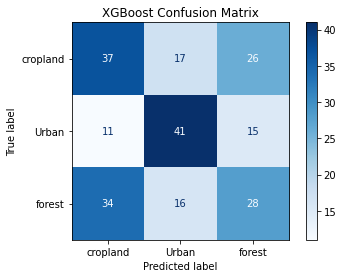

In [25]:
disp = plot_confusion_matrix(
    grid_search, X_test, y_test, 
    cmap=plt.cm.Blues,
    display_labels=['cropland', 'Urban', 'forest'])
disp.ax_.set_title("XGBoost Confusion Matrix")
plt.show()

Feature importance

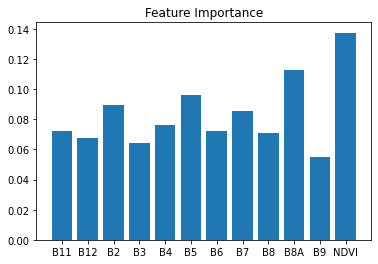

In [26]:
grid_search.best_estimator_.feature_importances_

plt.bar(x = X_train.columns, height = grid_search.best_estimator_.feature_importances_)
plt.title("Feature Importance")
plt.show()


# Bonus: how to extract time-series Sentinel2 data to points

First get a small subset of the entire dataset to save time

In [27]:
df.sort_values(by=['date'],inplace=True)
subset = df.iloc[:5,:3]
subset

,lat,long,date
52,0.357150,37.583587,2020-04-01
293,0.360634,37.587915,2020-04-15
72,3.119974,35.608017,2020-05-12
846,2.368688,38.023958,2020-05-26
7,2.329307,37.999144,2020-05-27


In [28]:
bands_s2 = ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']
def extract_timeseries_to_point(x):
    lat = x['lat']
    long = x['long']
    p = ee.Geometry.Point([long,lat])
    
    #Create an image collection with 6-month's sentinel2 images, one for each month
    d = x['date']
    date_list = [(d + timedelta(30*i)).strftime('%Y-%m-%d') for i in range(-3,4)]
    image_ls = []
    for i in range(0,6):
        s =  ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterDate(date_list[i], date_list[i+1]) \
        .sort('CLOUD_COVER') \
        .filterBounds(p).first()
        image_ls.append(s)
    img_col = ee.ImageCollection(image_ls)
    
    #Extract values from the image collection to the point of interest and save to a csv
    def extract(img):
        return img.select(bands_s2).sampleRegions(collection=p, scale=10, geometries=True)
    
    newft = ee.FeatureCollection(img_col.map(extract)).flatten()
    f = newft.getInfo()['features']
    keys = f[0]['properties'].keys()
    values = zip(f[0]['properties'].values(),f[1]['properties'].values(),f[2]['properties'].values(),f[3]['properties'].values(),f[4]['properties'].values(),f[5]['properties'].values())
    dictionary = dict(zip(keys, values))
    
    display(pd.DataFrame.from_dict(dictionary))
    pd.DataFrame.from_dict(dictionary).to_csv('timeseries/df_'+str(long)+'_'+str(lat)+'_'+d.strftime('%Y%m%d')+'.csv')
    
    return 1


In [29]:
subset.apply(extract_timeseries_to_point,axis=1)

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,1746,1288,411,741,900,1293,2330,2743,2768,2960,4046
1,1850,1262,393,678,705,1072,1848,2102,2229,2330,3027
2,1968,1494,875,1146,1194,1506,2226,2495,2536,2621,3821
3,719,522,307,379,371,500,775,932,863,954,1006
4,1794,1243,578,848,807,1278,2178,2377,2724,2510,3574
5,1979,1429,507,793,967,1325,2004,2216,2624,2490,2921


,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,2098,1606,415,675,770,1132,2057,2475,2369,2576,2706
1,2149,1665,485,709,682,1381,2418,3134,2932,3321,3226
2,2399,1897,534,800,916,1392,2296,2710,2472,2885,2910
3,6290,4973,12272,11256,10440,10927,10371,10215,10592,10027,15937
4,2131,1522,433,639,652,1182,2283,2729,2500,2824,2755
5,2962,2486,1618,1780,1924,2259,2757,3027,3002,3204,3153


,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,2307,1699,418,600,570,1076,2206,2516,2440,3005,2859
1,6001,4980,9848,9920,9728,10094,9749,9673,10072,9634,15495
2,2386,1704,789,875,815,1253,2582,2934,2668,3246,3138
3,2244,1854,502,683,620,1180,2541,2929,2700,3249,3107
4,5007,4652,4516,4540,4384,4968,4998,5047,5004,5064,10454
5,1526,1293,390,666,819,1055,1635,1915,1656,2114,1718


,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,3812,3227,3506,3436,3110,3648,4260,4477,4588,4556,6505
1,7202,5962,11144,10632,10136,10842,10284,10143,9880,9886,15801
2,5787,4942,7020,6812,6652,7097,7064,7098,6572,7108,10744
3,6719,5752,8728,8280,7828,8266,8175,8169,8164,8008,12240
4,3059,2030,1610,1838,1816,2068,2713,2992,3250,3230,3181
5,3308,3172,1908,2122,2172,2694,2962,3110,2922,3311,9278


,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,1901,1420,1009,1294,1416,1477,2351,2615,2494,2626,2431
1,3223,2807,4564,4232,3924,4256,4351,4373,3984,4394,7240
2,3392,3000,2898,2994,2858,3088,3837,4061,4094,4084,4316
3,4152,3558,4592,4052,3768,4068,4669,4881,5084,4938,7949
4,1382,851,589,682,648,970,1767,1998,1848,2117,2634
5,2400,2151,1140,1302,1328,1766,2343,2588,2348,2761,5611


52     1
293    1
72     1
846    1
7      1
dtype: int64